# Inerpretation-Net Training

## Specitication of Experiment Settings

In [1]:
#######################################################################################################################################
###################################################### CONFIG FILE ####################################################################
#######################################################################################################################################
sleep_time = 0 #minutes

config = {
    'data': {
        'd': 2, #degree
        'n': 9, #number of variables
        'monomial_vars': None, #int or None
        'laurent': True, #use Laurent polynomials (negative degree with up to -d)  
        'neg_d': 0,#int or None
        'neg_d_prob': 0,
        'sparsity': None,
        'sample_sparsity': None,
        'x_max': 1,
        'x_min': 0.05,
        'x_distrib': 'uniform', #'normal', 'uniform', 'beta', 'Gamma', 'laplace'
        'a_max': 1,
        'a_min': -1,
        'lambda_nets_total': 50000,
        'noise': 0.15,
        'noise_distrib': 'normal', #'normal', 'uniform', 'beta', 'Gamma', 'laplace'
        
        'border_min': 0.2, #needs to be between 0 and (x_max-x_min)/2
        'border_max': 0.4,
        'lower_degree_prob': 0.5,
        'a_zero_prob': 0.25,
        'a_random_prob': 0.1,      
        
        'same_training_all_lambda_nets': False,

        'fixed_seed_lambda_training': True,
        'fixed_initialization_lambda_training': False,
        'number_different_lambda_trainings': 1,
    },
    'lambda_net': {
        'epochs_lambda': 1000,
        'early_stopping_lambda': True,  #if early stopping is used, multi_epoch_analysis is deactivated
        'early_stopping_min_delta_lambda': 1e-4,
        'batch_lambda': 64,
        'dropout': 0,
        'lambda_network_layers': [5*'sparsity'],
        'optimizer_lambda': 'adam',
        'loss_lambda': 'mae',
        'number_of_lambda_weights': None,
        'lambda_dataset_size': 5000,
    },
    'i_net': {
        'optimizer': 'custom',#adam
        'inet_loss': 'mae',
        'inet_metrics': ['r2'],
        'dropout': 0.25,
        'dropout_output': 0,
        'epochs': 500, 
        'early_stopping': True,
        'batch_size': 256,
        'dense_layers': [512, 1024],
        'convolution_layers': None,
        'lstm_layers': None,
        'interpretation_dataset_size': 50000,
                
        'interpretation_net_output_monomials': None, #(None, int) #CONSTANT IS NOT INCLUDED
        'interpretation_net_output_shape': None, #calculated automatically later
        'test_size': 100, #Float for fraction, Int for number 0
        
        'normalize_inet_data': True,

        'evaluate_with_real_function': False,
        'consider_labels_training': False,
                      
        'data_reshape_version': None, #default to 2 options:(None, 0,1 2)
        'nas': False,
        'nas_type': 'SEQUENTIAL', #options:(None, 'SEQUENTIAL', 'CNN', 'LSTM', 'CNN-LSTM', 'CNN-LSTM-parallel')      
        'nas_trials': 100,
    },
    'evaluation': {   
        'inet_holdout_seed_evaluation': False,
        
        #set if multi_epoch_analysis should be performed
        'multi_epoch_analysis': True,
        'each_epochs_save_lambda': 100,
        'epoch_start': 0, #use to skip first epochs in multi_epoch_analysis
        
        #set if samples analysis should be performed
        'samples_list': None,#[100, 500, 750, 1000, 2500, 5000, 7500, 10000, 15000, 20000, 25000, 28125] 
       
        'random_evaluation_dataset_size': 500,
    },
    'computation':{
        'n_jobs': -3,
        'use_gpu': False,
        'gpu_numbers': '0',
        'RANDOM_SEED': 42,   
    }
}

## Imports

In [2]:
#######################################################################################################################################
########################################### IMPORT GLOBAL VARIABLES FROM CONFIG #######################################################
#######################################################################################################################################
globals().update(config['data'])
globals().update(config['lambda_net'])
globals().update(config['i_net'])
globals().update(config['evaluation'])
globals().update(config['computation'])

In [3]:
#######################################################################################################################################
##################################################### IMPORT LIBRARIES ################################################################
#######################################################################################################################################
from itertools import product       
from tqdm import tqdm_notebook as tqdm
import pickle
import numpy as np
import pandas as pd
import scipy as sp
import timeit
import psutil

from functools import reduce
from more_itertools import random_product 
from sklearn.preprocessing import Normalizer

import sys
import os
import shutil

import logging

from prettytable import PrettyTable
import colored
import math

import time
from datetime import datetime
from collections.abc import Iterable


from joblib import Parallel, delayed

from scipy.integrate import quad

from sklearn.model_selection import cross_val_score, train_test_split, StratifiedKFold, KFold, ParameterGrid, ParameterSampler
from sklearn.metrics import accuracy_score, log_loss, roc_auc_score, f1_score, mean_absolute_error, r2_score

from similaritymeasures import frechet_dist, area_between_two_curves, dtw
import keras
from keras.models import Sequential
from keras.layers.core import Dense, Dropout
from keras.utils import plot_model
from IPython.display import Image

import keras.backend as K
from livelossplot import PlotLossesKerasTF
from keras_tqdm import TQDMNotebookCallback
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

from matplotlib import pyplot as plt
import seaborn as sns


import tensorflow as tf
import random 


import warnings


from IPython.display import display, Math, Latex, clear_output



In [4]:
#######################################################################################################################################
################################################### VARIABLE ADJUSTMENTS ##############################################################
#######################################################################################################################################
variables = 'abcdefghijklmnopqrstuvwxyz'[:n]

n_jobs = min((epochs_lambda//each_epochs_save_lambda+1, n_jobs)) if multi_epoch_analysis else min(len(samples_list), n_jobs) if samples_list!=None else 1

multi_epoch_analysis = False if early_stopping_lambda else multi_epoch_analysis #deactivate multi_epoch_analysis if early stopping is used

each_epochs_save_lambda = each_epochs_save_lambda if multi_epoch_analysis else epochs_lambda
epochs_save_range_lambda = range(epoch_start//each_epochs_save_lambda, epochs_lambda//each_epochs_save_lambda) if each_epochs_save_lambda == 1 else range(epoch_start//each_epochs_save_lambda, epochs_lambda//each_epochs_save_lambda+1) if multi_epoch_analysis else range(1,2)

data_reshape_version = 2 if data_reshape_version == None and (convolution_layers != None or lstm_layers != None or (nas and nas_type != 'SEQUENTIAL')) else data_reshape_version
#######################################################################################################################################
###################################################### SET VARIABLES + DESIGN #########################################################
#######################################################################################################################################

#os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2' 
os.environ['CUDA_VISIBLE_DEVICES'] = gpu_numbers if use_gpu else ''

logging.getLogger('tensorflow').disabled = True

sns.set_style("darkgrid")
#np.set_printoptions(suppress=True)

random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)
if int(tf.__version__[0]) >= 2:
    tf.random.set_seed(RANDOM_SEED)
else:
    tf.set_random_seed(RANDOM_SEED)
    
    
pd.set_option('display.float_format', lambda x: '%.3f' % x)
pd.set_option('display.max_columns', 500)

warnings.filterwarnings('ignore')

sys.path.append('..')

In [5]:
from utilities.utility_functions import flatten, rec_gen

list_of_monomial_identifiers_extended = []

if laurent:
    variable_sets = [list(flatten([[_d for _d in range(d+1)], [-_d for _d in range(1, neg_d+1)]])) for _ in range(n)]
    list_of_monomial_identifiers_extended = rec_gen(variable_sets)    
        
    print('List length: ' + str(len(list_of_monomial_identifiers_extended)))
    #print('Number of monomials in a polynomial with ' + str(n) + ' variables and degree ' + str(d) + ': ' + str(sparsity))
    #print('Sparsity:' + str(sparsity))
    print(list_of_monomial_identifiers_extended)        
else:
    variable_sets = [[_d for _d in range(d+1)] for _ in range(n)]  
    list_of_monomial_identifiers_extended = rec_gen(variable_sets)

    print('List length: ' + str(len(list_of_monomial_identifiers_extended)))
    #print('Number of monomials in a polynomial with ' + str(n) + ' variables and degree ' + str(d) + ': ' + str(sparsity))
    #print('Sparsity: ' + str(sparsity))
    print(list_of_monomial_identifiers_extended)

list_of_monomial_identifiers = []
for monomial_identifier in tqdm(list_of_monomial_identifiers_extended):
    if np.sum(monomial_identifier) <= d:
        if monomial_vars == None or len(list(filter(lambda x: x != 0, monomial_identifier))) <= monomial_vars:
            list_of_monomial_identifiers.append(monomial_identifier)

print('List length: ' + str(len(list_of_monomial_identifiers)))
#print('Number of monomials in a polynomial with ' + str(n) + ' variables and degree ' + str(d) + ': ' + str(sparsity))
#print('Sparsity: ' + str(sparsity))
print(list_of_monomial_identifiers)


List length: 19683
[[0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 1], [0, 0, 0, 0, 0, 0, 0, 0, 2], [0, 0, 0, 0, 0, 0, 0, 1, 0], [0, 0, 0, 0, 0, 0, 0, 1, 1], [0, 0, 0, 0, 0, 0, 0, 1, 2], [0, 0, 0, 0, 0, 0, 0, 2, 0], [0, 0, 0, 0, 0, 0, 0, 2, 1], [0, 0, 0, 0, 0, 0, 0, 2, 2], [0, 0, 0, 0, 0, 0, 1, 0, 0], [0, 0, 0, 0, 0, 0, 1, 0, 1], [0, 0, 0, 0, 0, 0, 1, 0, 2], [0, 0, 0, 0, 0, 0, 1, 1, 0], [0, 0, 0, 0, 0, 0, 1, 1, 1], [0, 0, 0, 0, 0, 0, 1, 1, 2], [0, 0, 0, 0, 0, 0, 1, 2, 0], [0, 0, 0, 0, 0, 0, 1, 2, 1], [0, 0, 0, 0, 0, 0, 1, 2, 2], [0, 0, 0, 0, 0, 0, 2, 0, 0], [0, 0, 0, 0, 0, 0, 2, 0, 1], [0, 0, 0, 0, 0, 0, 2, 0, 2], [0, 0, 0, 0, 0, 0, 2, 1, 0], [0, 0, 0, 0, 0, 0, 2, 1, 1], [0, 0, 0, 0, 0, 0, 2, 1, 2], [0, 0, 0, 0, 0, 0, 2, 2, 0], [0, 0, 0, 0, 0, 0, 2, 2, 1], [0, 0, 0, 0, 0, 0, 2, 2, 2], [0, 0, 0, 0, 0, 1, 0, 0, 0], [0, 0, 0, 0, 0, 1, 0, 0, 1], [0, 0, 0, 0, 0, 1, 0, 0, 2], [0, 0, 0, 0, 0, 1, 0, 1, 0], [0, 0, 0, 0, 0, 1, 0, 1, 1], [0, 0, 0, 0, 0, 1, 0, 1, 2], [0, 0, 0, 0, 0, 1, 0, 2

  0%|          | 0/19683 [00:00<?, ?it/s]

List length: 55
[[0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 1], [0, 0, 0, 0, 0, 0, 0, 0, 2], [0, 0, 0, 0, 0, 0, 0, 1, 0], [0, 0, 0, 0, 0, 0, 0, 1, 1], [0, 0, 0, 0, 0, 0, 0, 2, 0], [0, 0, 0, 0, 0, 0, 1, 0, 0], [0, 0, 0, 0, 0, 0, 1, 0, 1], [0, 0, 0, 0, 0, 0, 1, 1, 0], [0, 0, 0, 0, 0, 0, 2, 0, 0], [0, 0, 0, 0, 0, 1, 0, 0, 0], [0, 0, 0, 0, 0, 1, 0, 0, 1], [0, 0, 0, 0, 0, 1, 0, 1, 0], [0, 0, 0, 0, 0, 1, 1, 0, 0], [0, 0, 0, 0, 0, 2, 0, 0, 0], [0, 0, 0, 0, 1, 0, 0, 0, 0], [0, 0, 0, 0, 1, 0, 0, 0, 1], [0, 0, 0, 0, 1, 0, 0, 1, 0], [0, 0, 0, 0, 1, 0, 1, 0, 0], [0, 0, 0, 0, 1, 1, 0, 0, 0], [0, 0, 0, 0, 2, 0, 0, 0, 0], [0, 0, 0, 1, 0, 0, 0, 0, 0], [0, 0, 0, 1, 0, 0, 0, 0, 1], [0, 0, 0, 1, 0, 0, 0, 1, 0], [0, 0, 0, 1, 0, 0, 1, 0, 0], [0, 0, 0, 1, 0, 1, 0, 0, 0], [0, 0, 0, 1, 1, 0, 0, 0, 0], [0, 0, 0, 2, 0, 0, 0, 0, 0], [0, 0, 1, 0, 0, 0, 0, 0, 0], [0, 0, 1, 0, 0, 0, 0, 0, 1], [0, 0, 1, 0, 0, 0, 0, 1, 0], [0, 0, 1, 0, 0, 0, 1, 0, 0], [0, 0, 1, 0, 0, 1, 0, 0, 0], [0, 0, 1, 0, 1, 0, 0, 0, 0

In [6]:
from utilities.InterpretationNet import *
from utilities.LambdaNet import *
from utilities.metrics import *
from utilities.utility_functions import *
#######################################################################################################################################
####################################################### CONFIG ADJUSTMENTS ############################################################
#######################################################################################################################################
config['evaluation']['multi_epoch_analysis'] = multi_epoch_analysis
config['evaluation']['each_epochs_save_lambda'] = each_epochs_save_lambda
config['i_net']['data_reshape_version'] = data_reshape_version

config['data']['sparsity'] = nCr(config['data']['n']+config['data']['d'], config['data']['d']) if not laurent else len(list_of_monomial_identifiers)
config['data']['sample_sparsity'] = config['data']['sparsity'] if config['data']['sample_sparsity'] == None else config['data']['sample_sparsity']

config['i_net']['interpretation_net_output_shape'] = config['data']['sparsity'] if config['i_net']['interpretation_net_output_monomials'] is None else config['data']['sparsity']*config['i_net']['interpretation_net_output_monomials']+config['i_net']['interpretation_net_output_monomials']


transformed_layers = []
for layer in config['lambda_net']['lambda_network_layers']:
    if type(layer) == str:
        transformed_layers.append(layer.count('sparsity')*config['data']['sparsity'])
    else:
        transformed_layers.append(layer)
config['lambda_net']['lambda_network_layers'] = transformed_layers

layers_with_input_output = list(flatten([[config['data']['n']], config['lambda_net']['lambda_network_layers'], [1]]))
number_of_lambda_weights = 0
for i in range(len(layers_with_input_output)-1):
    number_of_lambda_weights += (layers_with_input_output[i]+1)*layers_with_input_output[i+1]  
config['lambda_net']['number_of_lambda_weights'] = number_of_lambda_weights
    
#######################################################################################################################################
################################################## UPDATE VARIABLES ###################################################################
#######################################################################################################################################
globals().update(config['data'])
globals().update(config['lambda_net'])
globals().update(config['i_net'])
globals().update(config['evaluation'])
globals().update(config['computation'])



initialize_LambdaNet_config_from_curent_notebook(config)
initialize_metrics_config_from_curent_notebook(config)
initialize_utility_functions_config_from_curent_notebook(config)
initialize_InterpretationNet_config_from_curent_notebook(config)


#######################################################################################################################################
###################################################### PATH + FOLDER CREATION #########################################################
#######################################################################################################################################
globals().update(generate_paths(path_type='interpretation_net'))
create_folders_inet()

#######################################################################################################################################
############################################################ SLEEP TIMER ##############################################################
#######################################################################################################################################
sleep_minutes(sleep_time)

In [7]:
print(path_identifier_interpretation_net_data)

print(path_identifier_lambda_net_data)


inet_dense512-1024-output_55_drop0.25e500b256_custom/lnets_50000_275-1000e_ES0.0001_64b_adam_mae_train_5000_diffX_1-FixSeed_42/var_9_d_2_laurent_negd_0_prob_0_spars_55_amin_-1_amax_1_xdist_uniform_noise_normal_0.15bmin0.2bmax0.4lowd0.5azero0.25arand0.1
lnets_50000_275-1000e_ES0.0001_64b_adam_mae_train_5000_diffX_1-FixSeed_42/var_9_d_2_laurent_negd_0_prob_0_spars_55_amin_-1_amax_1_xdist_uniform_noise_normal_0.15bmin0.2bmax0.4lowd0.5azero0.25arand0.1


In [8]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
print("Num XLA-GPUs Available: ", len(tf.config.experimental.list_physical_devices('XLA_GPU')))

Num GPUs Available:  0
Num XLA-GPUs Available:  0


## Load Data and Generate Datasets

In [9]:
def load_lambda_nets(index):
    
    if psutil.virtual_memory().percent > 80:
        raise SystemExit("Out of RAM!")
    
    directory = './data/weights/' + 'weights_' + path_identifier_lambda_net_data + '/'
    path_weights = directory + 'weights_epoch_' + str(index).zfill(3) + '.txt'
    path_X_data = directory + 'lambda_X_test_data.txt'
    path_y_data = directory + 'lambda_y_test_data.txt'        
    
    weight_data = pd.read_csv(path_weights, sep=",", header=None)
    weight_data = weight_data.sort_values(by=0).sample(frac=1, random_state=RANDOM_SEED)
    weight_data = weight_data.sort_values(by=0).sample(n=interpretation_dataset_size, random_state=RANDOM_SEED)
    
    lambda_X_test_data = pd.read_csv(path_X_data, sep=",", header=None)
    lambda_X_test_data = lambda_X_test_data.sort_values(by=0).sample(frac=1, random_state=RANDOM_SEED)
    lambda_X_test_data = lambda_X_test_data.sort_values(by=0).sample(n=interpretation_dataset_size, random_state=RANDOM_SEED)
    
    lambda_y_test_data = pd.read_csv(path_y_data, sep=",", header=None)
    lambda_y_test_data = lambda_y_test_data.sort_values(by=0).sample(frac=1, random_state=RANDOM_SEED)
    lambda_y_test_data = lambda_y_test_data.sort_values(by=0).sample(n=interpretation_dataset_size, random_state=RANDOM_SEED)
        
    lambda_nets = [None] * weight_data.shape[0]
    for i, (row_weights, row_lambda_X_test_data, row_lambda_y_test_data) in enumerate(zip(weight_data.values, lambda_X_test_data.values, lambda_y_test_data.values)):        
        lambda_net = LambdaNet(row_weights, row_lambda_X_test_data, row_lambda_y_test_data)
        lambda_nets[i] = lambda_net
                
    lambda_net_dataset = LambdaNetDataset(lambda_nets)
        
    return lambda_net_dataset
    

In [10]:
#LOAD DATA

parallel = Parallel(n_jobs=n_jobs, verbose=3, backend='multiprocessing')
lambda_net_dataset_list = parallel(delayed(load_lambda_nets)((i+1)*each_epochs_save_lambda if each_epochs_save_lambda==1 else i*each_epochs_save_lambda if i > 1 else each_epochs_save_lambda if i==1 else 1) for i in epochs_save_range_lambda)  
del parallel

lambda_net_dataset = lambda_net_dataset_list[-1]


[Parallel(n_jobs=-3)]: Using backend MultiprocessingBackend with 22 concurrent workers.
[Parallel(n_jobs=-3)]: Done   1 out of   1 | elapsed:  9.8min finished


## Data Inspection

In [11]:
lambda_net_dataset.as_pandas().head()

seed  000000000-target  000000001-target  000000002-target  \
33553  1373158606            -0.278            -0.667            -0.234   
9427   1373158606            -0.131             0.830            -0.700   
199    1373158606             0.360            -0.884             0.858   
12447  1373158606             0.088            -0.031            -0.050   
39489  1373158606            -0.554            -0.054            -0.761   

       000000010-target  000000011-target  000000020-target  000000100-target  \
33553            -0.161            -0.706             0.321            -0.960   
9427             -0.436            -0.003            -0.641             0.294   
199              -0.555             0.999            -0.657             0.543   
12447             0.522             0.888             0.295            -0.280   
39489            -0.447            -0.387             0.157             0.654   

       000000101-target  000000110-target  000000200-target  000001000-target  \
33553            -0.786            -0.789            -0.921            -0.466   
9427              0.403             0.083             0.710             0.852   
199              -0.553            -0.838             0.750             0.718   
12447            -0.620            -0.300             0.503             0.331   
39489            -0.644            -0.461            -0.230             0.321   

       000001001-target  000001010-target  000001100-target  000002000-target  \
33553             0.352             0.617            -0.600             0.188   
9427              0.654             0.580             0.576            -0.798   
199              -0.193             0.405             0.114             0.706   
12447             0.966             0.092             0.814            -0.631   
39489            -0.420             0.849            -0.870             0.717   

       000010000-target  000010001-target  000010010-target  000010100-target  \
33553            -0.186             0.003             0.787             0.512   
9427              0.431            -0.042            -0.664             0.823   
199              -0.370             0.047            -0.029            -0.292   
12447            -0.748            -0.376             0.412             0.489   
39489            -0.535             0.101             0.045            -0.776   

       000011000-target  000020000-target  000100000-target  000100001-target  \
33553             0.125            -0.271            -0.022             0.009   
9427             -0.509             0.561             0.794             0.064   
199               0.783            -0.668            -0.701             0.154   
12447            -0.218             0.363            -0.265             0.302   
39489             0.610             0.906            -0.538             0.135   

       000100010-target  000100100-target  000101000-target  000110000-target  \
33553            -0.102             0.896            -0.015             0.586   
9427              0.117             0.333             0.161            -0.337   
199               0.315            -0.611            -0.219             0.893   
12447            -0.662             0.732             0.486            -0.797   
39489            -0.625            -0.707             0.256            -0.123   

       000200000-target  001000000-target  001000001-target  001000010-target  \
33553             0.246            -0.532             0.500             0.028   
9427             -0.032            -0.438             0.936             0.499   
199              -0.507             0.337             0.480            -0.104   
12447             0.512            -0.421             0.605            -0.775   
39489             0.346             0.688            -0.276             0.955   

       001000100-target  001001000-target  001010000-target  001100000-target  \
33553            -0.403             0.341             0.372             

In [12]:
lambda_net_dataset.as_pandas().describe()

seed  000000000-target  000000001-target  000000002-target  \
count      50000.000         50000.000         50000.000         50000.000   
mean  1373158606.000            -0.002             0.002             0.005   
std            0.000             0.577             0.577             0.578   
min   1373158606.000            -1.000            -1.000            -1.000   
25%   1373158606.000            -0.501            -0.497            -0.494   
50%   1373158606.000            -0.004             0.007             0.008   
75%   1373158606.000             0.497             0.500             0.507   
max   1373158606.000             1.000             1.000             1.000   

       000000010-target  000000011-target  000000020-target  000000100-target  \
count         50000.000         50000.000         50000.000         50000.000   
mean             -0.002            -0.001            -0.002             0.001   
std               0.576             0.577             0.579             0.578   
min              -1.000            -1.000            -1.000            -1.000   
25%              -0.498            -0.501            -0.505            -0.501   
50%              -0.005            -0.002            -0.000             0.000   
75%               0.496             0.500             0.502             0.504   
max               1.000             1.000             1.000             1.000   

       000000101-target  000000110-target  000000200-target  000001000-target  \
count         50000.000         50000.000         50000.000         50000.000   
mean              0.004             0.002            -0.002            -0.002   
std               0.577             0.577             0.576             0.577   
min              -1.000            -1.000            -1.000            -1.000   
25%              -0.497            -0.496            -0.501            -0.496   
50%               0.007             0.004            -0.005            -0.004   
75%               0.503             0.500             0.496             0.498   
max               1.000             1.000             1.000             1.000   

       000001001-target  000001010-target  000001100-target  000002000-target  \
count         50000.000         50000.000         50000.000         50000.000   
mean             -0.001            -0.002             0.002             0.001   
std               0.577             0.577             0.575             0.577   
min              -1.000            -1.000            -1.000            -1.000   
25%              -0.496            -0.500            -0.494            -0.499   
50%              -0.003            -0.003             0.000             0.002   
75%               0.500             0.497             0.499             0.498   
max               1.000             1.000             1.000             1.000   

       000010000-target  000010001-target  000010010-target  000010100-target  \
count         50000.000         50000.000         50000.000         50000.000   
mean             -0.003            -0.005            -0.003            -0.003   
std               0.579             0.577             0.576             0.578   
min              -1.000            -1.000            -1.000            -1.000   
25%              -0.501            -0.508            -0.503            -0.507   
50%              -0.006            -0.007            -0.003            -0.009   
75%               0.499             0.497             0.494             0.498   
max               1.000             1.000             1.000             1.000   

       000011000-target  000020000-target  000100000-target  000100001-target  \
count         50000.000         50000.000         50000.000         50000.000   
mean              0.003            -0.003            -0.002            -0.001   
std               0.577             0.579             0.577             0.577   
min              -1.000            -1.000            -1.000          

In [13]:
lambda_net_dataset.X_test_data_list[0][:10]

array([[0.73082941, 0.05213017, 0.66572068, 0.87712713, 0.06067624,
        0.09081775, 0.72254459, 0.20717409, 0.4915632 ],
       [0.624057  , 0.90447014, 0.92468088, 0.93750586, 0.65198702,
        0.44290109, 0.35719106, 0.71362528, 0.38521999],
       [0.20728853, 0.3990572 , 0.23764756, 0.50852175, 0.94043697,
        0.8591    , 0.34855253, 0.87088499, 0.99980287],
       [0.58654567, 0.8845656 , 0.90932963, 0.90834534, 0.62394553,
        0.8081525 , 0.91104895, 0.75970973, 0.96291015],
       [0.8217497 , 0.33359407, 0.6376189 , 0.62417853, 0.67121809,
        0.66421107, 0.52845012, 0.51743737, 0.97099857],
       [0.60145068, 0.17803421, 0.38437711, 0.67995954, 0.98294559,
        0.52212317, 0.62965456, 0.13924224, 0.75433468],
       [0.7222318 , 0.81118147, 0.21146383, 0.56395218, 0.82417586,
        0.83460542, 0.3015649 , 0.88933477, 0.25549277],
       [0.73541227, 0.09589284, 0.53089947, 0.84096981, 0.90104095,
        0.86411768, 0.26617861, 0.48882316, 0.82097931],


In [14]:
lambda_net_dataset.y_test_data_list[0][:10]

array([[-1.13771771],
       [ 0.47982393],
       [-0.42441769],
       [-0.91328845],
       [ 0.04898086],
       [-0.48349864],
       [ 1.47318748],
       [ 1.01904184],
       [ 0.77653566],
       [-0.80453525]])

## Generate Datasets for Interpretation-Net training

In [15]:
#generate train, test and validation data for training

lambda_net_train_dataset_list = []
lambda_net_valid_dataset_list = []
lambda_net_test_dataset_list = []

for lambda_net_dataset in lambda_net_dataset_list:
    
    
    if inet_holdout_seed_evaluation:
        complete_seed_list = list(set(lambda_net_dataset.train_settings_list['seed']))#list(weight_data.iloc[:,1].unique())

        random.seed(RANDOM_SEED)
        
        if isinstance(test_size, float):
            test_size = int(len(complete_seed_list)-len(complete_seed_list)/(1/(1-test_size)))
        
        test_seeds = random.sample(complete_seed_list, test_size)
        lambda_net_test_dataset = lambda_net_dataset.get_lambda_nets_by_seed(test_seeds)
        complete_seed_list = list(set(complete_seed_list) - set(test_seeds))#complete_seed_list.remove(test_seeds)
        
        random.seed(RANDOM_SEED)
        valid_seeds = random.sample(complete_seed_list, int(len(complete_seed_list)-len(complete_seed_list)/(1/(1-0.1))))
        lambda_net_valid_dataset = lambda_net_dataset.get_lambda_nets_by_seed(valid_seeds)
        complete_seed_list = list(set(complete_seed_list) - set(valid_seeds))

        train_seeds = complete_seed_list
        lambda_net_train_dataset = lambda_net_dataset.get_lambda_nets_by_seed(train_seeds)       
        
        lambda_net_train_dataset_list.append(lambda_net_train_dataset)
        lambda_net_valid_dataset_list.append(lambda_net_valid_dataset)
        lambda_net_test_dataset_list.append(lambda_net_test_dataset)
        
        del lambda_net_dataset
    else:
        lambda_net_train_with_valid_dataset, lambda_net_test_dataset = split_LambdaNetDataset(lambda_net_dataset, test_split=test_size)
        lambda_net_train_dataset, lambda_net_valid_dataset = split_LambdaNetDataset(lambda_net_train_with_valid_dataset, test_split=0.1)
        
        lambda_net_train_dataset_list.append(lambda_net_train_dataset)
        lambda_net_valid_dataset_list.append(lambda_net_valid_dataset)
        lambda_net_test_dataset_list.append(lambda_net_test_dataset)
    
        del lambda_net_dataset, lambda_net_train_with_valid_dataset

        
del lambda_net_dataset_list

In [16]:
lambda_net_train_dataset_list[-1].as_pandas().shape

(44910, 3192)

In [17]:
lambda_net_valid_dataset_list[-1].as_pandas().shape

(4990, 3192)

In [18]:
lambda_net_test_dataset_list[-1].as_pandas().shape

(100, 3192)

In [19]:
lambda_net_train_dataset_list[-1].as_pandas().head()

seed  000000000-target  000000001-target  000000002-target  \
9901   1373158606            -0.573             0.604             0.985   
5910   1373158606            -0.561             0.918            -0.312   
18619  1373158606            -0.658            -0.156            -0.220   
33312  1373158606             0.412            -0.144             0.449   
47430  1373158606             0.820            -0.435            -0.994   

       000000010-target  000000011-target  000000020-target  000000100-target  \
9901             -0.216            -0.916            -0.688             0.468   
5910             -0.810            -0.739            -0.656            -0.602   
18619            -0.442            -0.128             0.868             0.122   
33312            -0.213            -0.165            -0.150            -0.956   
47430            -0.924             0.210             0.784            -0.226   

       000000101-target  000000110-target  000000200-target  000001000-target  \
9901             -0.830            -0.195             0.685            -0.408   
5910              0.530            -0.159            -0.701            -0.951   
18619             0.239             0.532            -0.855             0.927   
33312             0.129             0.392            -0.267             0.249   
47430             0.960            -0.471            -0.784            -0.891   

       000001001-target  000001010-target  000001100-target  000002000-target  \
9901             -0.711             0.991            -0.992             0.055   
5910             -0.408             0.338             0.278            -0.345   
18619             0.703            -0.352            -0.708             0.238   
33312             0.738            -0.136             0.236            -0.744   
47430            -0.659             0.370            -0.959             0.486   

       000010000-target  000010001-target  000010010-target  000010100-target  \
9901             -0.992            -0.708            -0.871            -0.824   
5910              0.095             0.023            -0.117            -0.089   
18619            -0.710             0.104             0.470             0.487   
33312            -0.316             0.151             0.584             0.591   
47430             0.360             0.117             0.422            -0.609   

       000011000-target  000020000-target  000100000-target  000100001-target  \
9901              0.370             0.952             0.883            -0.211   
5910             -0.716             0.764             0.166            -0.514   
18619             0.840            -0.069            -0.289             0.082   
33312             0.869             0.682            -0.088             0.917   
47430            -0.864             0.218             0.888             0.803   

       000100010-target  000100100-target  000101000-target  000110000-target  \
9901             -0.253            -0.858             0.085            -0.438   
5910             -0.159            -0.761             0.644            -0.116   
18619             0.479             0.297             0.783             0.696   
33312            -0.812             0.583             0.650             0.482   
47430             0.368            -0.154            -0.579            -0.672   

       000200000-target  001000000-target  001000001-target  001000010-target  \
9901             -0.503             0.609            -0.999             0.415   
5910             -0.278             0.384             0.237            -0.468   
18619             0.725             0.665            -0.338            -0.591   
33312            -0.223             0.832            -0.928            -0.978   
47430             0.619            -0.157             0.808            -0.483   

       001000100-target  001001000-target  001010000-target  001100000-target  \
9901              0.006            -0.688             0.996             

In [20]:
lambda_net_valid_dataset_list[-1].as_pandas().head()

seed  000000000-target  000000001-target  000000002-target  \
7038   1373158606             0.069            -0.690            -0.646   
30770  1373158606             0.516             0.868            -0.809   
41342  1373158606            -0.169            -0.950             0.017   
21084  1373158606             0.686             0.648             0.772   
47211  1373158606            -0.727            -0.209             0.996   

       000000010-target  000000011-target  000000020-target  000000100-target  \
7038              0.219             0.824            -0.861            -0.269   
30770            -0.565            -0.666            -0.275            -0.222   
41342             0.277             0.562            -0.264             0.711   
21084             0.709             0.027             0.563             0.615   
47211            -0.182             0.706            -0.478            -0.207   

       000000101-target  000000110-target  000000200-target  000001000-target  \
7038              0.974             0.069            -0.025            -0.065   
30770             0.847            -0.017            -0.096             0.034   
41342            -0.453            -0.990             0.420             0.416   
21084            -0.781             0.147             0.295             0.027   
47211            -0.971            -0.411             0.153             0.989   

       000001001-target  000001010-target  000001100-target  000002000-target  \
7038             -0.923             0.476             0.777             0.383   
30770             0.706            -0.349            -0.637            -0.453   
41342             0.763             0.440             0.440             0.205   
21084            -0.042             0.966            -0.034            -0.206   
47211             0.323            -0.614             0.158            -0.488   

       000010000-target  000010001-target  000010010-target  000010100-target  \
7038             -0.670             0.566             0.175             0.953   
30770            -0.680            -0.729             0.307            -0.790   
41342             0.889            -0.765             0.041            -0.831   
21084            -0.617             0.280             0.128            -0.153   
47211             0.571             0.444             0.360            -0.808   

       000011000-target  000020000-target  000100000-target  000100001-target  \
7038              0.682            -0.897             0.612             0.910   
30770            -0.270             0.098            -0.706            -0.586   
41342             0.291             0.773            -0.838            -0.178   
21084            -0.663            -0.889             0.395            -0.354   
47211             0.296             0.224            -0.807             0.158   

       000100010-target  000100100-target  000101000-target  000110000-target  \
7038              0.262             0.656             0.510            -0.091   
30770            -0.116            -0.164            -0.886            -0.332   
41342            -0.362            -0.262             0.176             0.110   
21084             0.770             0.216            -0.417            -0.199   
47211             0.966             0.982             0.009            -0.675   

       000200000-target  001000000-target  001000001-target  001000010-target  \
7038             -0.585             0.412             0.425            -0.937   
30770             0.383            -0.618             0.293            -0.935   
41342            -0.812             0.365             0.765            -0.197   
21084            -0.659            -0.672             0.791            -0.688   
47211            -0.976             0.102            -0.638             0.836   

       001000100-target  001001000-target  001010000-target  001100000-target  \
7038             -0.475            -0.050            -0.952            -

In [21]:
lambda_net_test_dataset_list[-1].as_pandas().head()

seed  000000000-target  000000001-target  000000002-target  \
35587  1373158606            -0.504            -0.292             0.595   
32681  1373158606            -0.152             0.146             0.135   
40971  1373158606             0.130             0.854            -0.511   
21022  1373158606            -0.454             0.004             0.378   
6403   1373158606             0.532             0.794            -0.808   

       000000010-target  000000011-target  000000020-target  000000100-target  \
35587            -0.354            -0.615             0.236            -0.489   
32681            -0.284             0.913             0.750             0.365   
40971             0.702            -0.262            -0.207             0.213   
21022            -0.284             0.541             0.492             0.568   
6403             -0.471            -0.281             0.428             0.260   

       000000101-target  000000110-target  000000200-target  000001000-target  \
35587            -0.443            -0.373             0.040            -0.455   
32681            -0.678            -0.271             0.064             0.579   
40971            -0.955            -0.358             0.576             0.086   
21022            -0.288            -0.540             0.313            -0.528   
6403              0.729             0.748             0.407             0.895   

       000001001-target  000001010-target  000001100-target  000002000-target  \
35587            -0.676             0.048            -0.455             0.891   
32681            -0.035             0.701            -0.129            -0.309   
40971            -0.295            -0.490            -0.395            -0.322   
21022             0.877             0.115             0.107             0.776   
6403             -0.392            -0.279            -0.716             0.575   

       000010000-target  000010001-target  000010010-target  000010100-target  \
35587             0.812            -0.986            -0.613            -0.024   
32681             0.102             0.371             0.165            -0.347   
40971            -0.136             0.119            -0.220             0.341   
21022            -0.289            -0.044             0.933            -0.870   
6403              0.189            -0.598             0.756            -0.819   

       000011000-target  000020000-target  000100000-target  000100001-target  \
35587            -0.980            -0.547            -0.009            -0.945   
32681            -0.775            -0.557             0.562             0.613   
40971             0.882             0.322             0.406            -0.663   
21022            -0.121             0.308             0.557            -0.658   
6403             -0.029             0.102            -0.199            -0.801   

       000100010-target  000100100-target  000101000-target  000110000-target  \
35587             0.772             0.353            -0.211             0.632   
32681             0.896            -0.199             0.735             0.564   
40971             0.136            -0.180             0.128            -0.792   
21022            -0.873            -0.998             0.731             0.783   
6403              0.382            -0.551             0.488             0.983   

       000200000-target  001000000-target  001000001-target  001000010-target  \
35587            -0.792            -0.966            -0.573             0.721   
32681            -0.223             0.133             0.137             0.711   
40971            -0.683             0.782             0.773            -0.284   
21022            -0.059            -0.675             0.725            -0.461   
6403             -0.088             0.714            -0.333             0.281   

       001000100-target  001001000-target  001010000-target  001100000-target  \
35587            -0.650            -0.517             0.912            -

## Interpretation Network Training

In [22]:
#%load_ext autoreload

----------------------------------------------- TRAINING INTERPRETATION NET -----------------------------------------------


[Parallel(n_jobs=-3)]: Using backend LokyBackend with 22 concurrent workers.
[Parallel(n_jobs=-3)]: Done   6 tasks      | elapsed:   13.8s
[Parallel(n_jobs=-3)]: Done 156 tasks      | elapsed:   17.9s
[Parallel(n_jobs=-3)]: Done 406 tasks      | elapsed:   24.2s
[Parallel(n_jobs=-3)]: Done 756 tasks      | elapsed:   33.4s
[Parallel(n_jobs=-3)]: Done 1206 tasks      | elapsed:   45.0s
[Parallel(n_jobs=-3)]: Done 1756 tasks      | elapsed:   59.3s
[Parallel(n_jobs=-3)]: Done 2406 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-3)]: Done 3156 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-3)]: Done 4006 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-3)]: Done 4956 tasks      | elapsed:  2.4min
[Parallel(n_jobs=-3)]: Done 6006 tasks      | elapsed:  2.9min
[Parallel(n_jobs=-3)]: Done 7156 tasks      | elapsed:  3.4min
[Parallel(n_jobs=-3)]: Done 8406 tasks      | elapsed:  3.9min
[Parallel(n_jobs=-3)]: Done 9756 tasks      | elapsed:  4.6min
[Parallel(n_jobs=-3)]: Done 11206 tasks      

Training Time: 3:15:42
---------------------------------------------------------------------------------------------------------------------------
------------------------------------------------------ LOADING MODELS -----------------------------------------------------
Loading Time: 0:00:00
---------------------------------------------------------------------------------------------------------------------------
------------------------------------------------------- PREDICT INET ------------------------------------------------------
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 3026)]            0         
_________________________________________________________________
hidden1_512 (Dense)          (None, 512)               1549824   
_________________________________________________________________
dropout1_0.25 (Dropout)      (None, 512)        

[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:  3.6min
[Parallel(n_jobs=10)]: Done 100 out of 100 | elapsed: 11.5min finished
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:  3.5min
[Parallel(n_jobs=10)]: Done 100 out of 100 | elapsed: 11.5min finished
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:  3.5min
[Parallel(n_jobs=10)]: Done 100 out of 100 | elapsed: 11.5min finished
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:  3.5min
[Parallel(n_jobs=10)]: Done 100 out of 100 | elapsed: 11.5min finished
Traceback (most recent call last):
  File "../utilities/InterpretationNet.py", line 1091, in calculate_all_function_values
    function_valu

<class 'KeyError'>
<class 'KeyError'>
<class 'KeyError'>
'symbolic_regression_functions'
EXIT symbolic_regression_functions
<class 'KeyError'>
FV Calculation Time: 0:46:31
---------------------------------------------------------------------------------------------------------------------------
----------------------------------------------------- CALCULATE SCORES ----------------------------------------------------
lambda_preds_VS_target_polynomials
[[-1.4735124  -2.1572666  -1.3732169  ... -1.1126307  -0.6441228
  -0.6422036 ]
 [-0.0429169   0.46455693  0.772085   ...  0.70582706  1.6010113
   1.0834671 ]
 [ 1.6932746   1.7307223   1.8474787  ...  0.5888206   0.92338145
   0.46484923]
 ...
 [ 0.25569516 -0.9437753   2.0037198  ... -0.77219325 -0.5965536
   0.3308092 ]
 [-0.74358624  2.8889487   3.6269355  ...  0.94167674  2.6172993
  -0.43174252]
 [ 3.7587287   2.1953933   3.9164605  ...  1.4925311   3.1641994
   2.8848407 ]]
[[-1.5445607  -2.2192614  -1.3902525  ... -1.1654903  -0.6

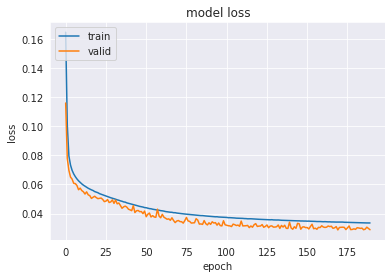

In [23]:
#%autoreload 2
(history_list, 

#scores_valid_list,
scores_test_list, 

#function_values_valid_list, 
function_values_test_list, 

#polynomial_dict_valid_list,
polynomial_dict_test_list,

#distrib_dict_valid_list,
distrib_dict_test_list,

model_list) = calculate_interpretation_net_results(lambda_net_train_dataset_list, 
                                                   lambda_net_valid_dataset_list, 
                                                   lambda_net_test_dataset_list)

## Evaluate Interpretation Net

In [24]:
polynomial_dict_test_list[-1].keys()

dict_keys(['lstsq_lambda_pred_polynomials', 'lstsq_target_polynomials', 'target_polynomials', 'inet_polynomials'])

In [25]:
poly_optimize = tf.constant([float(i) for i in range(interpretation_net_output_shape)])

if interpretation_net_output_monomials != None:
    poly_optimize_coeffs = poly_optimize[:interpretation_net_output_monomials]

    poly_optimize_identifiers_list = []
    for i in range(interpretation_net_output_monomials):
        poly_optimize_identifiers = tf.math.softmax(poly_optimize[sparsity*i+interpretation_net_output_monomials:sparsity*(i+1)+interpretation_net_output_monomials])
        poly_optimize_identifiers_list.append(poly_optimize_identifiers)
    poly_optimize_identifiers_list = tf.keras.backend.flatten(poly_optimize_identifiers_list)
    poly_optimize = tf.concat([poly_optimize_coeffs, poly_optimize_identifiers_list], axis=0)


In [26]:
poly_optimize

<tf.Tensor: shape=(55,), dtype=float32, numpy=
array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12.,
       13., 14., 15., 16., 17., 18., 19., 20., 21., 22., 23., 24., 25.,
       26., 27., 28., 29., 30., 31., 32., 33., 34., 35., 36., 37., 38.,
       39., 40., 41., 42., 43., 44., 45., 46., 47., 48., 49., 50., 51.,
       52., 53., 54.], dtype=float32)>

In [27]:
if nas:
    for trial in history_list[-1]: 
        print(trial.summary())

In [28]:
if len(model_list) >= 1:
    print(model_list[-1].summary())
    print(model_list[-1].get_config())

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 3026)]            0         
_________________________________________________________________
hidden1_512 (Dense)          (None, 512)               1549824   
_________________________________________________________________
dropout1_0.25 (Dropout)      (None, 512)               0         
_________________________________________________________________
hidden2_1024 (Dense)         (None, 1024)              525312    
_________________________________________________________________
output_1024 (Dense)          (None, 55)                56375     
Total params: 2,131,511
Trainable params: 2,131,511
Non-trainable params: 0
_________________________________________________________________
None
{'name': 'model', 'layers': [{'class_name': 'InputLayer', 'config': {'batch_input_shape': (None, 3026), 'dtype':

In [29]:
if evaluate_with_real_function:
    keys = ['inetPoly_VS_targetPoly_test', 'perNetworkPoly_VS_targetPoly_test', 'predLambda_VS_targetPoly_test', 'lstsqLambda_VS_targetPoly_test', 'lstsqTarget_VS_targetPoly_test']
else:
    keys = ['inetPoly_VS_predLambda_test', 'inetPoly_VS_lstsqLambda_test', 'perNetworkPoly_VS_predLambda_test', 'perNetworkPoly_VS_lstsqLambda_test', 'lstsqLambda_VS_predLambda_test', 'predLambda_VS_targetPoly_test']

In [30]:
scores_test_list[-1]

MAE  RMSE  MAPE  \
lambda_preds_VS_target_polynomials                   NaN   NaN   NaN   
lambda_preds_VS_lstsq_lambda_pred_polynomials        NaN   NaN   NaN   
lambda_preds_VS_lstsq_target_polynomials             NaN   NaN   NaN   
lambda_preds_VS_inet_polynomials                     NaN   NaN   NaN   
target_polynomials_VS_lstsq_lambda_pred_polynom... 0.058 0.085 0.553   
target_polynomials_VS_lstsq_target_polynomials     0.019 0.025 0.180   
target_polynomials_VS_inet_polynomials             0.242 0.313 1.740   
lstsq_lambda_pred_polynomials_VS_lstsq_target_p... 0.055 0.081 0.394   
lstsq_lambda_pred_polynomials_VS_inet_polynomials  0.226 0.289 1.926   
lstsq_target_polynomials_VS_inet_polynomials       0.242 0.313 1.821   

                                                    Accuracy  \
lambda_preds_VS_target_polynomials                       NaN   
lambda_preds_VS_lstsq_lambda_pred_polynomials            NaN   
lambda_preds_VS_lstsq_target_polynomials                 NaN   
lambda_preds_VS_inet_polynomials                         NaN   
target_polynomials_VS_lstsq_lambda_pred_polynom...     0.522   
target_polynomials_VS_lstsq_target_polynomials         0.820   
target_polynomials_VS_inet_polynomials                 0.134   
lstsq_lambda_pred_polynomials_VS_lstsq_target_p...     0.547   
lstsq_lambda_pred_polynomials_VS_inet_polynomials      0.147   
lstsq_target_polynomials_VS_inet_polynomials           0.137   

                                                    Accuracy Multilabel  \
lambda_preds_VS_target_polynomials                                  NaN   
lambda_preds_VS_lstsq_lambda_pred_polynomials                       NaN   
lambda_preds_VS_lstsq_target_polynomials                            NaN   
lambda_preds_VS_inet_polynomials                                    NaN   
target_polynomials_VS_lstsq_lambda_pred_polynom...                0.000   
target_polynomials_VS_lstsq_target_polynomials                    0.000   
target_polynomials_VS_inet_polynomials                            0.000   
lstsq_lambda_pred_polynomials_VS_lstsq_target_p...                0.000   
lstsq_lambda_pred_polynomials_VS_inet_polynomials                 0.000   
lstsq_target_polynomials_VS_inet_polynomials                      0.000   

                                                    MAE FV  RMSE FV  MAPE FV  \
lambda_preds_VS_target_polynomials                   0.037    0.049    0.248   
lambda_preds_VS_lstsq_lambda_pred_polynomials        0.035    0.045    0.244   
lambda_preds_VS_lstsq_target_polynomials             0.036    0.048    0.241   
lambda_preds_VS_inet_polynomials                     0.185    0.221    1.111   
target_polynomials_VS_lstsq_lambda_pred_polynom...   0.023    0.030    0.111   
target_polynomials_VS_lstsq_target_polynomials       0.009    0.011    0.042   
target_polynomials_VS_inet_polynomials               0.184    0.221    0.812   
lstsq_lambda_pred_polynomials_VS_lstsq_target_p...   0.022    0.028    0.105   
lstsq_lambda_pred_polynomials_VS_inet_polynomials    0.182    0.218    0.789   
lstsq_target_polynomials_VS_inet_polynomials         0.184    0.221    1.225   

                                                    R2 FV  RAAE FV  RMAE FV  \
lambda_preds_VS_target_polynomials                  0.997    0.039    0.261   
lambda_preds_VS_lstsq_lambda_pred_polynomials       0.998    0.036    0.228   
lambda_preds_VS_lstsq_target_polynomials            0.997    0.038    0.261   
lambda_preds_VS_inet_polynomials                    0.943    0.189    0.553   
target_polynomials_VS_lstsq_lambda_pred_polynom...  0.999    0.024    0.114   
target_polynomials_VS_lstsq_target_polynomials      1.000    0.009    0.041   
target_polynomials_VS_inet_polynomials              0.943    0.188    0.635   
lstsq_lambda_pred_polynomials_VS_lstsq_target_p...  0.999    0.023    0.105   
lstsq_lambda_pred_polynomials_VS_inet_polynomials   0.944    0.186    0.616   
lstsq_target_polynomials_VS_inet_polynomials        0.943 

In [31]:
distrib_dict_test_list[-1]['MAE']

L-0   L-1   L-2   L-3  \
lambda_preds_VS_target_polynomials                 0.041 0.035 0.035 0.042   
lambda_preds_VS_lstsq_lambda_pred_polynomials      0.039 0.032 0.033 0.036   
lambda_preds_VS_lstsq_target_polynomials           0.040 0.034 0.034 0.041   
lambda_preds_VS_inet_polynomials                   0.209 0.181 0.146 0.151   
target_polynomials_VS_lstsq_lambda_pred_polynom... 0.022 0.026 0.021 0.025   
target_polynomials_VS_lstsq_target_polynomials     0.009 0.007 0.008 0.009   
target_polynomials_VS_inet_polynomials             0.203 0.188 0.143 0.146   
lstsq_lambda_pred_polynomials_VS_lstsq_target_p... 0.022 0.024 0.019 0.025   
lstsq_lambda_pred_polynomials_VS_inet_polynomials  0.208 0.179 0.141 0.145   
lstsq_target_polynomials_VS_inet_polynomials       0.202 0.189 0.141 0.146   

                                                     L-4   L-5   L-6   L-7  \
lambda_preds_VS_target_polynomials                 0.037 0.036 0.034 0.035   
lambda_preds_VS_lstsq_lambda_pred_polynomials      0.032 0.033 0.032 0.033   
lambda_preds_VS_lstsq_target_polynomials           0.036 0.035 0.033 0.034   
lambda_preds_VS_inet_polynomials                   0.310 0.234 0.160 0.150   
target_polynomials_VS_lstsq_lambda_pred_polynom... 0.025 0.022 0.020 0.024   
target_polynomials_VS_lstsq_target_polynomials     0.007 0.009 0.008 0.008   
target_polynomials_VS_inet_polynomials             0.304 0.235 0.163 0.152   
lstsq_lambda_pred_polynomials_VS_lstsq_target_p... 0.023 0.021 0.018 0.023   
lstsq_lambda_pred_polynomials_VS_inet_polynomials  0.312 0.235 0.155 0.143   
lstsq_target_polynomials_VS_inet_polynomials       0.304 0.233 0.163 0.153   

                                                     L-8   L-9  L-10  L-11  \
lambda_preds_VS_target_polynomials                 0.035 0.036 0.036 0.035   
lambda_preds_VS_lstsq_lambda_pred_polynomials      0.031 0.034 0.032 0.033   
lambda_preds_VS_lstsq_target_polynomials           0.033 0.034 0.035 0.033   
lambda_preds_VS_inet_polynomials                   0.140 0.352 0.138 0.133   
target_polynomials_VS_lstsq_lambda_pred_polynom... 0.022 0.020 0.023 0.017   
target_polynomials_VS_lstsq_target_polynomials     0.008 0.008 0.007 0.009   
target_polynomials_VS_inet_polynomials             0.131 0.358 0.136 0.126   
lstsq_lambda_pred_polynomials_VS_lstsq_target_p... 0.019 0.018 0.022 0.015   
lstsq_lambda_pred_polynomials_VS_inet_polynomials  0.138 0.349 0.134 0.128   
lstsq_target_polynomials_VS_inet_polynomials       0.131 0.359 0.136 0.125   

                                                    L-12  L-13  L-14  L-15  \
lambda_preds_VS_target_polynomials                 0.037 0.034 0.042 0.039   
lambda_preds_VS_lstsq_lambda_pred_polynomials      0.033 0.033 0.040 0.039   
lambda_preds_VS_lstsq_target_polynomials           0.037 0.033 0.041 0.038   
lambda_preds_VS_inet_polynomials                   0.103 0.156 0.143 0.237   
target_polynomials_VS_lstsq_lambda_pred_polynom... 0.023 0.019 0.023 0.022   
target_polynomials_VS_lstsq_target_polynomials     0.009 0.008 0.009 0.010   
target_polynomials_VS_inet_polynomials             0.106 0.154 0.136 0.240   
lstsq_lambda_pred_polynomials_VS_lstsq_target_p... 0.022 0.017 0.023 0.022   
lstsq_lambda_pred_polynomials_VS_inet_polynomials  0.099 0.151 0.134 0.238   
lstsq_target_polynomials_VS_inet_polynomials       0.107 0.152 0.138 0.238   

                                                    L-16  L-17  L-18  L-19  \
lambda_preds_VS_target_polynomials                 0.040 0.033 0.037 0.040   
lambda_preds_VS_lstsq_lambda_pred_polynomials      0.035 0.032 0.034 0.038   
lambda_preds_VS_lstsq_target_polynomials           0.040 0.032 0.036 0.039   
lambda_preds_VS_inet_polynomials                   0.311 0.138 0.149 0.152   
target_polynomials_VS_lstsq_lambda_pred_polynom... 0.028 0.019 0.022 0.027   
target_polynomials_VS_lstsq_target_polynomials     0.008 0.007 0.008 0.009   
target_polynomials_VS_inet_polynomials             0.307 0.136 0.143 0.

In [32]:
distrib_dict_test_list[-1]['R2']

L-0   L-1   L-2   L-3  \
lambda_preds_VS_target_polynomials                 0.996 0.998 0.996 0.993   
lambda_preds_VS_lstsq_lambda_pred_polynomials      0.997 0.999 0.996 0.995   
lambda_preds_VS_lstsq_target_polynomials           0.996 0.998 0.996 0.994   
lambda_preds_VS_inet_polynomials                   0.923 0.964 0.937 0.931   
target_polynomials_VS_lstsq_lambda_pred_polynom... 0.999 0.999 0.998 0.998   
target_polynomials_VS_lstsq_target_polynomials     1.000 1.000 1.000 1.000   
target_polynomials_VS_inet_polynomials             0.928 0.962 0.936 0.937   
lstsq_lambda_pred_polynomials_VS_lstsq_target_p... 0.999 0.999 0.999 0.998   
lstsq_lambda_pred_polynomials_VS_inet_polynomials  0.924 0.965 0.938 0.936   
lstsq_target_polynomials_VS_inet_polynomials       0.929 0.961 0.937 0.938   

                                                     L-4   L-5   L-6   L-7  \
lambda_preds_VS_target_polynomials                 0.996 0.995 0.999 0.997   
lambda_preds_VS_lstsq_lambda_pred_polynomials      0.997 0.996 0.999 0.998   
lambda_preds_VS_lstsq_target_polynomials           0.996 0.995 0.999 0.998   
lambda_preds_VS_inet_polynomials                   0.789 0.837 0.976 0.957   
target_polynomials_VS_lstsq_lambda_pred_polynom... 0.998 0.998 1.000 0.999   
target_polynomials_VS_lstsq_target_polynomials     1.000 1.000 1.000 1.000   
target_polynomials_VS_inet_polynomials             0.793 0.836 0.975 0.955   
lstsq_lambda_pred_polynomials_VS_lstsq_target_p... 0.998 0.998 1.000 0.999   
lstsq_lambda_pred_polynomials_VS_inet_polynomials  0.787 0.839 0.977 0.959   
lstsq_target_polynomials_VS_inet_polynomials       0.794 0.839 0.975 0.955   

                                                     L-8   L-9  L-10  L-11  \
lambda_preds_VS_target_polynomials                 0.997 0.998 0.997 0.998   
lambda_preds_VS_lstsq_lambda_pred_polynomials      0.997 0.998 0.997 0.998   
lambda_preds_VS_lstsq_target_polynomials           0.997 0.998 0.997 0.998   
lambda_preds_VS_inet_polynomials                   0.954 0.837 0.953 0.976   
target_polynomials_VS_lstsq_lambda_pred_polynom... 0.999 0.999 0.999 1.000   
target_polynomials_VS_lstsq_target_polynomials     1.000 1.000 1.000 1.000   
target_polynomials_VS_inet_polynomials             0.958 0.834 0.955 0.977   
lstsq_lambda_pred_polynomials_VS_lstsq_target_p... 0.999 0.999 0.999 1.000   
lstsq_lambda_pred_polynomials_VS_inet_polynomials  0.955 0.841 0.955 0.977   
lstsq_target_polynomials_VS_inet_polynomials       0.958 0.834 0.954 0.978   

                                                    L-12  L-13  L-14  L-15  \
lambda_preds_VS_target_polynomials                 0.997 0.998 0.996 0.998   
lambda_preds_VS_lstsq_lambda_pred_polynomials      0.997 0.998 0.997 0.999   
lambda_preds_VS_lstsq_target_polynomials           0.997 0.998 0.996 0.999   
lambda_preds_VS_inet_polynomials                   0.977 0.962 0.962 0.954   
target_polynomials_VS_lstsq_lambda_pred_polynom... 0.999 0.999 0.999 1.000   
target_polynomials_VS_lstsq_target_polynomials     1.000 1.000 1.000 1.000   
target_polynomials_VS_inet_polynomials             0.976 0.961 0.961 0.954   
lstsq_lambda_pred_polynomials_VS_lstsq_target_p... 0.999 1.000 0.999 1.000   
lstsq_lambda_pred_polynomials_VS_inet_polynomials  0.979 0.962 0.963 0.954   
lstsq_target_polynomials_VS_inet_polynomials       0.976 0.962 0.960 0.954   

                                                    L-16  L-17  L-18  L-19  \
lambda_preds_VS_target_polynomials                 0.998 0.998 0.997 0.998   
lambda_preds_VS_lstsq_lambda_pred_polynomials      0.998 0.999 0.998 0.999   
lambda_preds_VS_lstsq_target_polynomials           0.998 0.998 0.997 0.998   
lambda_preds_VS_inet_polynomials                   0.912 0.973 0.961 0.980   
target_polynomials_VS_lstsq_lambda_pred_polynom... 0.999 0.999 0.999 0.999   
target_polynomials_VS_lstsq_target_polynomials     1.000 1.000 1.000 1.000   
target_polynomials_VS_inet_polynomials             0.914 0.972 0.963 0.

In [33]:
index_min = int(np.argmin(distrib_dict_test_list[-1]['R2'].loc['lambda_preds_VS_lstsq_target_polynomials']))
polynomial_inet = polynomial_dict_test_list[-1]['inet_polynomials'][index_min]

print(distrib_dict_test_list[-1]['R2'].loc['target_polynomials_VS_inet_polynomials'][index_min])

print_polynomial_from_coefficients(polynomial_inet)

0.8737359624965017


0.139674082398415*a**2 + 0.0231728367507458*a*b + 0.826591074466705*a*c - 0.106462970376015*a*d - 0.100787542760372*a*e - 0.378541052341461*a*f + 0.55018162727356*a*g - 0.370593369007111*a*h - 0.516550779342651*a*i + 0.0123551245778799*a - 0.287845492362976*b**2 - 0.175372168421745*b*c - 0.527156352996826*b*d - 0.664706766605377*b*e + 0.550862550735474*b*f + 0.192848399281502*b*g - 0.475733667612076*b*h + 0.0985299274325371*b*i - 0.324421405792236*b + 0.315333127975464*c**2 - 0.482436150312424*c*d - 0.311800241470337*c*e - 0.654436588287354*c*f + 0.726019620895386*c*g + 0.497165381908417*c*h - 0.0498262085020542*c*i + 0.486442387104034*c + 0.367536306381226*d**2 + 0.506404280662537*d*e - 0.347228556871414*d*f + 0.0496056377887726*d*g + 0.372714579105377*d*h - 0.0412951149046421*d*i - 0.218381449580193*d + 0.248163178563118*e**2 + 0.475428760051727*e*f + 0.554490089416504*e*g + 0.591283440589905*e*h - 0.545516788959503*e*i + 0.0280295889824629*e + 0.678640067577362*f**2 - 0.423032641410

In [34]:
index_min = int(np.argmin(distrib_dict_test_list[-1]['R2'].loc['lambda_preds_VS_lstsq_lambda_pred_polynomials']))
#polynomial_target = lambda_net_test_dataset.get_lambda_net_by_lambda_index(index_min).target_polynomial

print(distrib_dict_test_list[-1]['R2'].loc['lstsq_lambda_pred_polynomials_VS_inet_polynomials'][index_min])

polynomial_lambda = lambda_net_test_dataset.lstsq_lambda_pred_polynomial_list[index_min]
print_polynomial_from_coefficients(polynomial_lambda, force_complete_poly_representation=True)

0.8927558223495015


-0.0457806225254987*a**2 - 0.281148757773995*a*b + 0.85517361573341*a*c - 0.217954014836703*a*d - 0.565668388402276*a*e - 0.298233691479819*a*f + 0.825314188631389*a*g - 0.620970568169835*a*h - 0.683045236509224*a*i + 0.700140584264219*a - 0.390882464114299*b**2 - 0.254444220883257*b*c - 0.739803397331646*b*d - 0.877404023698852*b*e + 0.829927079279918*b*f + 0.400909618585945*b*g - 0.318544971891911*b*h + 0.357439504355307*b*i - 0.160656139765668*b + 0.274869594552167*c**2 - 0.739337351491674*c*d - 0.45029212496846*c*e - 0.918096455524394*c*f + 0.970930421172876*c*g + 0.461107307411267*c*h + 0.03614030954037*c*i + 0.754304661195762*c + 0.411378470653549*d**2 + 0.680889444543011*d*e - 0.859420238881441*d*f - 0.03327180934765*d*g + 0.760292843376736*d*h - 0.334673737346344*d*i + 0.271098378041839*d + 0.264175065080471*e**2 + 0.347602405993258*e*f + 0.631798843549672*e*g + 0.817312491155504*e*h - 0.762411816502738*e*i + 0.415428243129405*e + 0.772662211691491*f**2 - 0.666990931735053*f*g 

In [35]:
index_min = int(np.argmin(distrib_dict_test_list[-1]['R2'].loc['lambda_preds_VS_lstsq_target_polynomials']))
#polynomial_target = lambda_net_test_dataset.get_lambda_net_by_lambda_index(index_min).target_polynomial
polynomial_target = lambda_net_test_dataset.target_polynomial_list[index_min]
print_polynomial_from_coefficients(polynomial_target, force_complete_poly_representation=True)

-0.0739212007799092*a**2 - 0.305335089558525*a*b + 0.88396604661864*a*c - 0.270341538972863*a*d - 0.627699390271652*a*e - 0.29644651414249*a*f + 0.83566542650923*a*g - 0.635860756998146*a*h - 0.779609605292561*a*i + 0.820413311422288*a - 0.45041249281269*b**2 - 0.312599110758715*b*c - 0.721279218035245*b*d - 0.909372014251287*b*e + 0.765209973379838*b*f + 0.295554646120953*b*g - 0.357794266084314*b*h + 0.280220117871984*b*i + 0.0970961960686704*b + 0.290272314625569*c**2 - 0.846794501535497*c*d - 0.444392794645776*c*e - 0.99558638160426*c*f + 0.994817259295004*c*g + 0.513084429562559*c*h + 0.0571360576806228*c*i + 0.809694433515002*c + 0.280546002933117*d**2 + 0.680801234034444*d*e - 0.935487075437881*d*f - 0.163557981990634*d*g + 0.750262145791009*d*h - 0.394668493374286*d*i + 0.633112912729983*d + 0.212032721051135*e**2 + 0.406599589438374*e*f + 0.662180794797251*e*g + 0.884916834086843*e*h - 0.771567651588471*e*i + 0.422242467074998*e + 0.718443093967208*f**2 - 0.635959579943119*f*g

In [36]:
index_max = int(np.argmax(distrib_dict_test_list[-1]['R2'].loc['lambda_preds_VS_lstsq_target_polynomials']))
polynomial_inet = polynomial_dict_test_list[-1]['inet_polynomials'][index_max]

print(distrib_dict_test_list[-1]['R2'].loc['target_polynomials_VS_inet_polynomials'][index_max])

print_polynomial_from_coefficients(polynomial_inet)

0.9865193538937435


0.927239120006561*a**2 + 0.313506513834*a*b + 0.608300507068634*a*c + 0.458514899015427*a*d - 0.026633283123374*a*e - 0.757455170154572*a*f + 0.410918176174164*a*g - 0.220839709043503*a*h + 0.185746669769287*a*i + 1.15097391605377*a - 0.163269966840744*b**2 + 0.298841118812561*b*c - 0.811614632606506*b*d + 0.470807075500488*b*e - 0.497968286275864*b*f + 0.170828431844711*b*g + 0.764757335186005*b*h - 0.650567352771759*b*i - 0.177874132990837*b + 0.433293759822845*c**2 - 0.822215139865875*c*d + 0.431707471609116*c*e + 0.771975696086884*c*f - 0.0822078660130501*c*g + 0.378582894802094*c*h - 0.0110817858949304*c*i + 0.442116379737854*c - 0.138082817196846*d**2 + 0.177845701575279*d*e + 0.258032321929932*d*f - 0.921082317829132*d*g + 0.122330911457539*d*h - 0.39288267493248*d*i - 0.729294002056122*d + 0.250054866075516*e**2 + 0.249312832951546*e*f + 0.249376341700554*e*g + 0.531835436820984*e*h + 0.88835471868515*e*i + 0.744707703590393*e + 0.448714584112167*f**2 - 0.944539487361908*f*g + 

In [37]:
index_max = int(np.argmax(distrib_dict_test_list[-1]['R2'].loc['lambda_preds_VS_lstsq_target_polynomials']))
#polynomial_target = lambda_net_test_dataset.get_lambda_net_by_lambda_index(index_min).target_polynomial

print(distrib_dict_test_list[-1]['R2'].loc['target_polynomials_VS_lstsq_lambda_pred_polynomials'][index_max])

polynomial_lambda = lambda_net_test_dataset.lstsq_lambda_pred_polynomial_list[index_max]
print_polynomial_from_coefficients(polynomial_lambda, force_complete_poly_representation=True)

0.9995575241731798


0.707279166785798*a**2 + 0.60725927561796*a*b + 0.922392808841799*a*c + 0.102328065675568*a*d + 0.575349405563363*a*e - 0.350415799420846*a*f + 0.0740924546800964*a*g + 0.176327577040028*a*h + 0.260882414378981*a*i + 0.811170799539359*a + 0.0558266955269248*b**2 + 0.397027010214624*b*c - 0.63091365754741*b*d + 0.400013421032161*b*e - 0.339664472565287*b*f - 0.041695399925727*b*g + 0.742837024891698*b*h - 0.657606526934311*b*i - 0.609596784827297*b - 0.0937802337443599*c**2 - 0.7615147614156*c*d + 0.481251458111842*c*e + 0.596682167970781*c*f - 0.41966055423475*c*g + 0.510540370173747*c*h + 0.210039270453772*c*i + 0.875830435241942*c - 0.147011172741905*d**2 - 0.167730449711712*d*e + 0.490715394711029*d*f - 0.653165421379786*d*g - 0.409820108958879*d*h - 0.171278577024917*d*i - 0.585341791560041*d + 0.531169073031887*e**2 + 0.744445185977038*e*f - 0.0981040154910166*e*g + 0.931826373164436*e*h + 0.707947721246648*e*i + 0.315741323784647*e + 0.378607875178375*f**2 - 1.02687930156435*f*g 

In [38]:
index_max = int(np.argmax(distrib_dict_test_list[-1]['R2'].loc['lambda_preds_VS_lstsq_target_polynomials']))
#polynomial_target = lambda_net_test_dataset.get_lambda_net_by_lambda_index(index_min).target_polynomial
polynomial_target = lambda_net_test_dataset.target_polynomial_list[index_max]
print_polynomial_from_coefficients(polynomial_target, force_complete_poly_representation=True)

0.785614266020288*a**2 + 0.618071502956944*a*b + 0.90159175726629*a*c + 0.123108722532728*a*d + 0.603917460187271*a*e - 0.323481154576323*a*f + 0.0485022747853935*a*g + 0.0912493881390383*a*h + 0.339273539990543*a*i + 0.711164810362102*a + 0.117431686466124*b**2 + 0.47834519829928*b*c - 0.705419993164131*b*d + 0.490764632813467*b*e - 0.421022873127082*b*f - 0.0508449446097525*b*g + 0.779846922436263*b*h - 0.655106968059795*b*i - 0.691610717632194*b - 0.0721234600374984*c**2 - 0.790749815504135*c*d + 0.527970592872296*c*e + 0.762508291035353*c*f - 0.354198106413983*c*g + 0.503793095017986*c*h + 0.249792446063549*c*i + 0.665844662175192*c - 0.175919153461622*d**2 - 0.203526571199993*d*e + 0.525633194926644*d*f - 0.678444228019548*d*g - 0.385092268883174*d*h - 0.177146746117921*d*i - 0.532125199445575*d + 0.570254070918086*e**2 + 0.765395769733636*e*f - 0.131151434441442*e*g + 0.967540503944155*e*h + 0.709329772665405*e*i + 0.183890025431499*e + 0.453904050738982*f**2 - 0.988529618731791*

In [39]:
r2_values_inet = distrib_dict_test_list[-1]['R2'].loc['target_polynomials_VS_inet_polynomials']
print('Mean: ' + str(np.mean(r2_values_inet)) + ' (' + str(r2_values_inet.shape[0]) + ' Samples)')

r2_values_positive_inet = r2_values_inet[r2_values_inet>0]
print('Mean (only positive): ' + str(np.mean(r2_values_positive_inet)) + ' (' + str(r2_values_positive_inet.shape[0]) + ' Samples)')



Mean: 0.943065891688871 (100 Samples)
Mean (only positive): 0.943065891688871 (100 Samples)


In [40]:
r2_values_lstsq_lambda = distrib_dict_test_list[-1]['R2'].loc['target_polynomials_VS_lstsq_lambda_pred_polynomials']
print('Mean: ' + str(np.mean(r2_values_lstsq_lambda)) + ' (' + str(r2_values_inet.shape[0]) + ' Samples)')

r2_values_positive_lstsq_lambda = r2_values_lstsq_lambda[r2_values_lstsq_lambda>0]
print('Mean (only positive): ' + str(np.mean(r2_values_positive_lstsq_lambda)) + ' (' + str(r2_values_positive_lstsq_lambda.shape[0]) + ' Samples)')



Mean: 0.9989493624643295 (100 Samples)
Mean (only positive): 0.9989493624643295 (100 Samples)


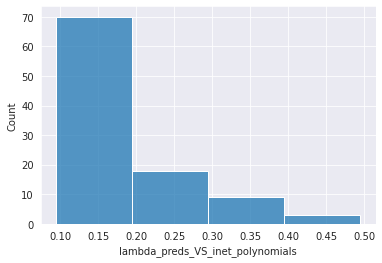

In [41]:
p = sns.histplot(distrib_dict_test_list[-1]['MAE'].loc['lambda_preds_VS_inet_polynomials'][distrib_dict_test_list[-1]['R2'].loc['lambda_preds_VS_inet_polynomials'] < 50], binwidth=0.1)
#p.set(xlim=(0, 20))


[(0.0, 1.0)]

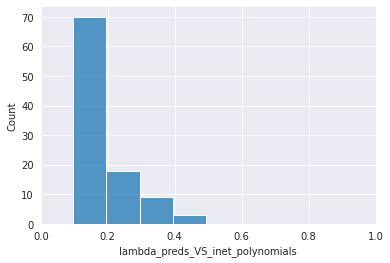

In [42]:
p = sns.histplot(distrib_dict_test_list[-1]['MAE'].loc['lambda_preds_VS_inet_polynomials'][distrib_dict_test_list[-1]['R2'].loc['lambda_preds_VS_inet_polynomials'] < 50], binwidth=0.1)
p.set(xlim=(0, 1))


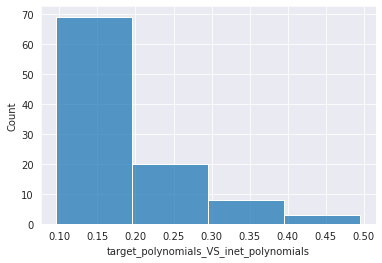

In [43]:
p = sns.histplot(distrib_dict_test_list[-1]['MAE'].loc['target_polynomials_VS_inet_polynomials'][distrib_dict_test_list[-1]['MAE'].loc['target_polynomials_VS_inet_polynomials'] < 50], binwidth=0.1)
#p.set(xlim=(0, 20))


[(0.0, 1.0)]

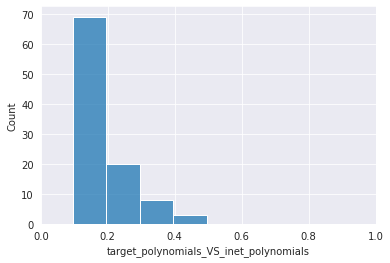

In [44]:
p = sns.histplot(distrib_dict_test_list[-1]['MAE'].loc['target_polynomials_VS_inet_polynomials'][distrib_dict_test_list[-1]['MAE'].loc['target_polynomials_VS_inet_polynomials'] < 50], binwidth=0.1)
p.set(xlim=(0, 1))


[(-30.0, 1.0)]

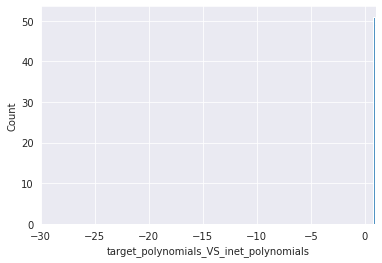

In [45]:
p = sns.histplot(distrib_dict_test_list[-1]['R2'].loc['target_polynomials_VS_inet_polynomials'][distrib_dict_test_list[-1]['R2'].loc['target_polynomials_VS_inet_polynomials'] > -50], binwidth=0.2)
p.set(xlim=(-30, 1))

[(0.0, 1.0)]

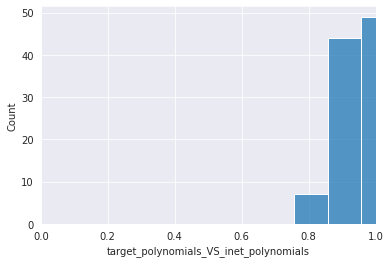

In [46]:
p = sns.histplot(distrib_dict_test_list[-1]['R2'].loc['target_polynomials_VS_inet_polynomials'][distrib_dict_test_list[-1]['R2'].loc['target_polynomials_VS_inet_polynomials'] > -50], binwidth=0.1)
p.set(xlim=(0, 1))

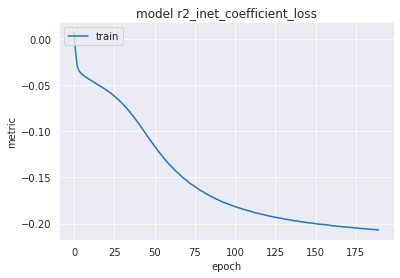

In [47]:
if not nas:
    history = history_list[-1]

    plt.plot(history[list(history.keys())[1]])
    if consider_labels_training or evaluate_with_real_function:
        plt.plot(history[list(history.keys())[len(history.keys())//2+1]]) 
    plt.title('model ' + list(history.keys())[1])
    plt.ylabel('metric')
    plt.xlabel('epoch')
    plt.legend(['train', 'valid'], loc='upper left')
    plt.savefig('./data/results/' + path_identifier_interpretation_net_data + '/metric_' + '_epoch_' + str(epochs_lambda).zfill(3) + '.png')


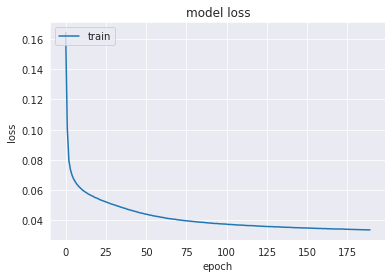

In [48]:
if not nas:
    history = history_list[-1]

    plt.plot(history['loss'])
    if consider_labels_training or evaluate_with_real_function:
        plt.plot(history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'valid'], loc='upper left')
    plt.savefig('./data/results/' + path_identifier_interpretation_net_data + '/loss_' + '_epoch_' + str(epochs_lambda).zfill(3) + '.png')    


### Multi Epoch/Sampes Analysis

### Generate Comparison Plots

In [49]:
if len(scores_test_list) > 1:
    plot_metric_list = ['MAE FV', 'RMSE FV', 'MAPE FV', 'R2 FV', 'RAAE FV', 'RMAE FV']

    generate_inet_comparison_plot(scores_test_list, plot_metric_list)

In [50]:
if len(scores_test_list) > 1:
    plot_metric_list = ['MAE FV']

    generate_inet_comparison_plot(scores_test_list, plot_metric_list)

In [51]:
if len(scores_test_list) > 1:
    plot_metric_list = ['R2 FV']

    generate_inet_comparison_plot(scores_test_list, plot_metric_list, ylim=(-5, 1))

#### Generate and Analyze Predictions for Random Function

In [52]:
index = 6

custom_representation_keys_fixed = ['target_polynomials', 'lstsq_target_polynomials', 'lstsq_lambda_pred_polynomials', 'lstsq_lambda_pred_polynomials']
custom_representation_keys_dynamic = ['inet_polynomials', 'per_network_polynomials']
sympy_representation_keys = ['metamodel_functions']


print('------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------')

for key in polynomial_dict_test_list[-1].keys():
    print('------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------')
    print(key)
    if key in custom_representation_keys_fixed:
        print_polynomial_from_coefficients(polynomial_dict_test_list[-1][key][index], force_complete_poly_representation=True, round_digits=4)
    elif key in custom_representation_keys_dynamic:
        print_polynomial_from_coefficients(polynomial_dict_test_list[-1][key][index], round_digits=4)
    else:
        display(polynomial_dict_test_list[-1][key][index])

print('------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------')
print('------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------')


------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
lstsq_lambda_pred_polynomials


0.1898*a**2 - 0.2057*a*b + 0.6828*a*c - 0.2341*a*d - 0.1028*a*e - 0.7039*a*f - 0.176*a*g - 0.2431*a*h - 0.6231*a*i - 0.0081*a + 0.6341*b**2 + 0.7881*b*c + 0.7433*b*d + 0.4193*b*e + 0.8473*b*f + 0.7891*b*g + 0.5768*b*h - 0.1427*b*i + 0.0471*b - 0.0388*c**2 + 0.8329*c*d - 0.0474*c*e + 0.864*c*f + 0.0856*c*g - 0.3877*c*h + 0.0828*c*i + 1.1429*c - 0.4551*d**2 + 0.5492*d*e - 0.6328*d*f - 0.9364*d*g + 0.8458*d*h - 0.9892*d*i + 0.3656*d + 0.2987*e**2 + 0.6114*e*f - 0.4581*e*g + 0.3045*e*h + 0.3707*e*i - 0.9207*e + 0.0022*f**2 + 0.3368*f*g - 0.4193*f*h - 0.5772*f*i + 0.0216*f - 0.5169*g**2 + 0.8991*g*h - 0.7337*g*i - 1.1307*g + 0.1729*h**2 - 0.3908*h*i - 0.2033*h + 0.6163*i**2 - 0.5676*i - 1.0403

------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
lstsq_target_polynomials


0.2088*a**2 - 0.1833*a*b + 0.7108*a*c - 0.219*a*d - 0.1219*a*e - 0.7037*a*f - 0.1933*a*g - 0.2261*a*h - 0.6702*a*i - 0.0282*a + 0.6832*b**2 + 0.8143*b*c + 0.7983*b*d + 0.4195*b*e + 0.8938*b*f + 0.7897*b*g + 0.5923*b*h - 0.1465*b*i - 0.0905*b + 0.0211*c**2 + 0.9127*c*d - 0.0448*c*e + 0.9389*c*f + 0.0657*c*g - 0.433*c*h + 0.1232*c*i + 0.9873*c - 0.495*d**2 + 0.5433*d*e - 0.6231*d*f - 1.0031*d*g + 0.8407*d*h - 1.0176*d*i + 0.4059*d + 0.3102*e**2 + 0.6281*e*f - 0.4692*e*g + 0.3199*e*h + 0.3614*e*i - 0.9469*e + 0.0263*f**2 + 0.3253*f*g - 0.4056*f*h - 0.6201*f*i - 0.0649*f - 0.5684*g**2 + 0.8648*g*h - 0.8089*g*i - 0.9827*g + 0.2074*h**2 - 0.4123*h*i - 0.2028*h + 0.6725*i**2 - 0.5109*i - 0.9978

------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
target_polynomials


0.2301*a**2 - 0.1897*a*b + 0.7283*a*c - 0.2189*a*d - 0.1376*a*e - 0.708*a*f - 0.1805*a*g - 0.234*a*h - 0.6943*a*i - 0.0386*a + 0.7005*b**2 + 0.8451*b*c + 0.809*b*d + 0.4118*b*e + 0.9329*b*f + 0.8076*b*g + 0.5856*b*h - 0.1282*b*i - 0.1539*b + 0.0542*c**2 + 0.9142*c*d - 0.0707*c*e + 0.9578*c*f + 0.0576*c*g - 0.4388*c*h + 0.1182*c*i + 0.931*c - 0.5123*d**2 + 0.5729*d*e - 0.6323*d*f - 0.9872*d*g + 0.8317*d*h - 0.9965*d*i + 0.3901*d + 0.3263*e**2 + 0.6496*e*f - 0.4741*e*g + 0.3*e*h + 0.3728*e*i - 0.9558*e + 0.036*f**2 + 0.3053*f*g - 0.3977*f*h - 0.6228*f*i - 0.1066*f - 0.5758*g**2 + 0.8732*g*h - 0.7998*g*i - 0.9866*g + 0.1865*h**2 - 0.3987*h*i - 0.1631*h + 0.6919*i**2 - 0.5639*i - 0.9449

------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
inet_polynomials


0.0216000005602837*a**2 - 0.341800004243851*a*b + 1.16820001602173*a*c - 0.350199997425079*a*d - 0.457899987697601*a*e - 0.479200005531311*a*f - 0.219099998474121*a*g - 0.149900004267693*a*h - 0.490799993276596*a*i + 0.00600000005215406*a + 0.201800003647804*b**2 + 0.834200024604797*b*c + 0.292699992656708*b*d + 0.634899973869324*b*e + 0.806599974632263*b*f + 0.470299988985062*b*g + 0.412200003862381*b*h + 0.177699998021126*b*i + 0.672299981117249*b + 0.324699997901917*c**2 + 0.613399982452393*c*d - 0.386400014162064*c*e + 0.827000021934509*c*f - 0.341699987649918*c*g - 0.245399996638298*c*h - 0.276199996471405*c*i + 1.07949995994568*c - 0.289700001478195*d**2 + 0.563499987125397*d*e - 0.306300014257431*d*f - 0.563300013542175*d*g + 0.831200003623962*d*h - 0.3716000020504*d*i - 0.142700001597404*d - 0.138099998235703*e**2 + 0.513300001621246*e*f - 0.401600003242493*e*g + 0.104000002145767*e*h - 0.0672999992966652*e*i - 0.11429999768734*e - 0.0625*f**2 + 0.115599997341633*f*g - 0.510999

------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------


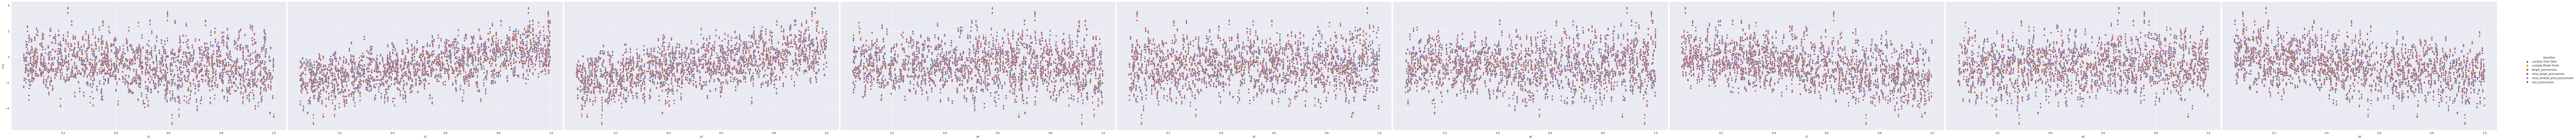

In [53]:
plot_and_save_single_polynomial_prediction_evaluation(lambda_net_test_dataset_list, 
                                                      function_values_test_list, 
                                                      polynomial_dict_test_list,
                                                      rand_index=index, 
                                                      plot_type=1)

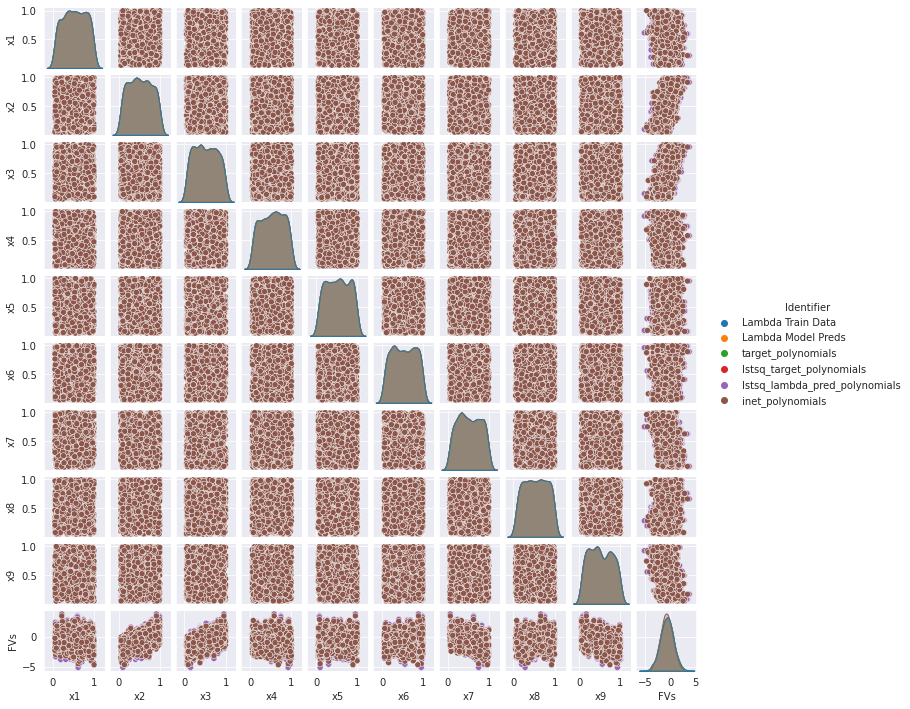

In [54]:
plot_and_save_single_polynomial_prediction_evaluation(lambda_net_test_dataset_list, 
                                                      function_values_test_list, 
                                                      polynomial_dict_test_list,
                                                      rand_index=index, 
                                                      plot_type=2)

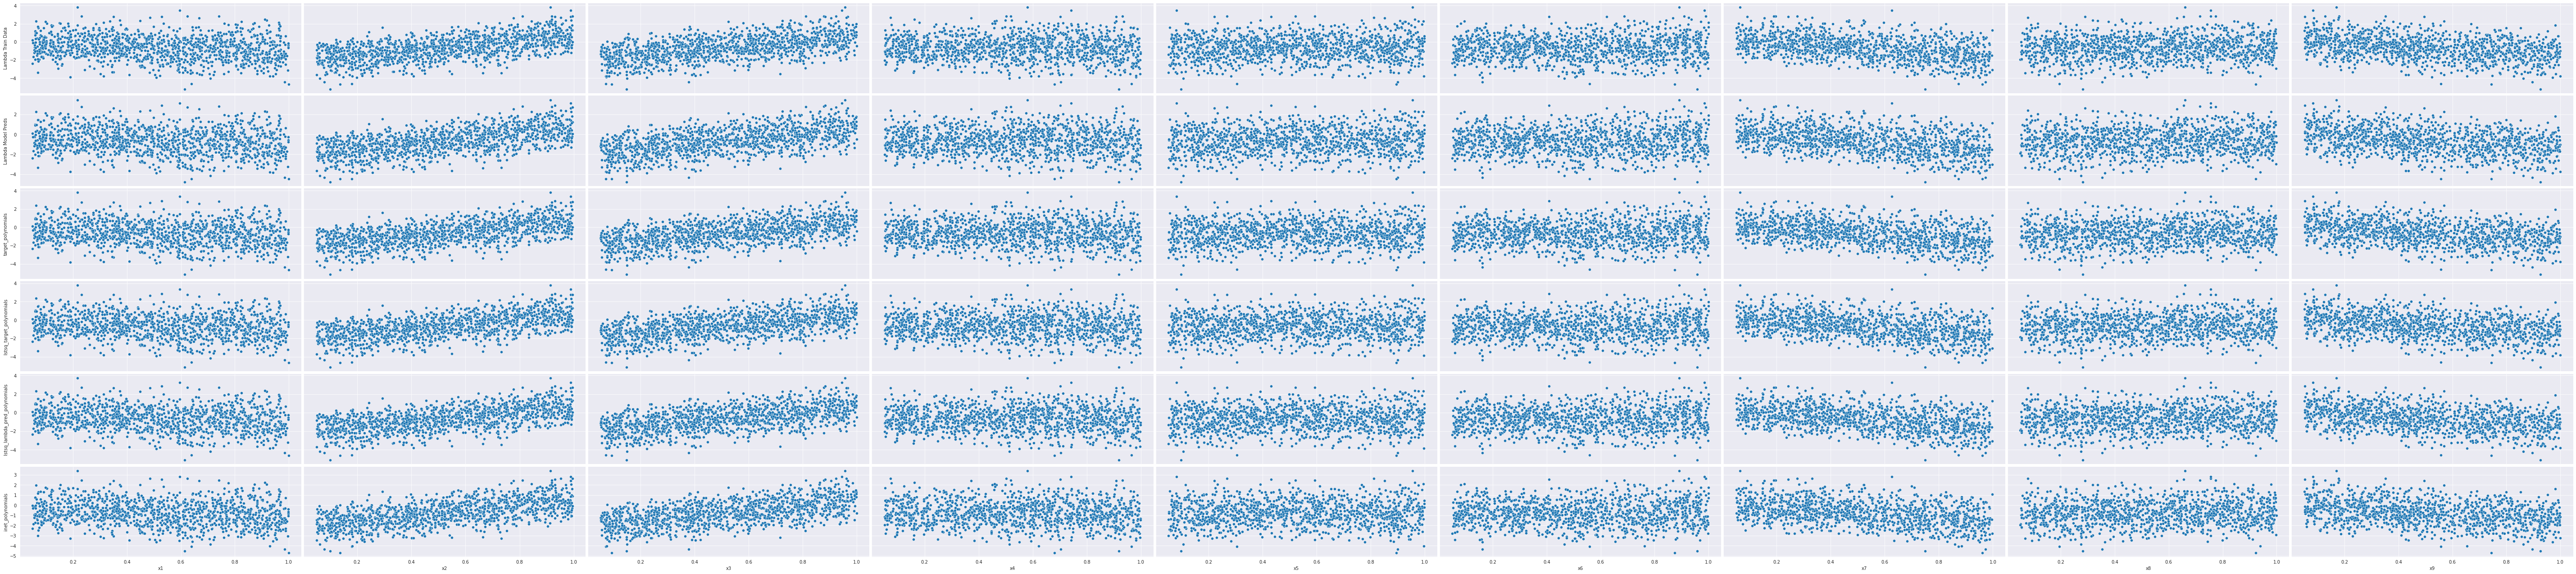

In [55]:
plot_and_save_single_polynomial_prediction_evaluation(lambda_net_test_dataset_list, 
                                                      function_values_test_list, 
                                                      polynomial_dict_test_list,
                                                      rand_index=index, 
                                                      plot_type=3)

# BENCHMARK (RANDOM GUESS) EVALUATION

In [56]:
list_of_random_polynomials = np.random.uniform(low=-10, high=10, size=(len(lambda_net_test_dataset_list[-1]), sparsity))

In [57]:
true_fv_test = parallel_fv_calculation_from_polynomial(lambda_net_test_dataset_list[-1].target_polynomial_list, lambda_net_test_dataset_list[-1].X_test_data_list, force_complete_poly_representation=True)
random_fv_test = parallel_fv_calculation_from_polynomial(list_of_random_polynomials, lambda_net_test_dataset_list[-1].X_test_data_list, force_complete_poly_representation=True)

[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:  3.5min
[Parallel(n_jobs=10)]: Done 100 out of 100 | elapsed: 11.6min finished
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:  3.6min
[Parallel(n_jobs=10)]: Done 100 out of 100 | elapsed: 11.6min finished


In [58]:
print('Random Guess Error Coefficients: ' + str(np.round(mean_absolute_error(lambda_net_test_dataset_list[-1].target_polynomial_list, list_of_random_polynomials), 4)))

Random Guess Error Coefficients: 5.043


In [59]:
print('Random Guess Error FVs: ' + str(np.round(mean_absolute_error_function_values(true_fv_test, random_fv_test), 4)))

Random Guess Error FVs: 13.4548


# BENCHMARK (EDUCATED GUESS/MEAN PREDICTION) EVALUATION

In [60]:
true_fv_train = parallel_fv_calculation_from_polynomial(lambda_net_test_dataset_list[-1].target_polynomial_list, lambda_net_test_dataset_list[-1].X_test_data_list, force_complete_poly_representation=True)

mean_fv = np.mean(true_fv_train)
mean_fv_pred_test = [mean_fv for _ in range(true_fv_test.shape[0])]

[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:  3.6min
[Parallel(n_jobs=10)]: Done 100 out of 100 | elapsed: 11.6min finished


In [61]:
print('Educated Guess/Mean Prediction Error FVs: ' + str(np.round(mean_absolute_error_function_values(true_fv_test, mean_fv_pred_test), 4)))

Educated Guess/Mean Prediction Error FVs: 1.4092


In [62]:
%%script false --no-raise-error

base_model = generate_base_model()
random_evaluation_dataset = np.random.uniform(low=x_min, high=x_max, size=(random_evaluation_dataset_size, n))
#random_evaluation_dataset = lambda_train_input_train_split[0]#lambda_train_input[0] #JUST [0] HERE BECAUSE EVALUATION ALWAYS ON THE SAME DATASET FOR ALL!!
list_of_monomial_identifiers_numbers = np.array([list(monomial_identifiers) for monomial_identifiers in list_of_monomial_identifiers]).astype(float)


loss_function = mean_absolute_error_tf_fv_lambda_extended_wrapper(random_evaluation_dataset, list_of_monomial_identifiers_numbers, base_model)      

X_train = X_train_list[-1].values[:,1:]
y_train = y_train_list[-1].values[:,2:]

#X_train = X_train[:,1:]
y_train_model = np.hstack((y_train, X_train))

print('seed_in_inet_training = ' + str(seed_in_inet_training), loss_function(y_train_model, y_train))


seed_in_inet_training = False

loss_function = mean_absolute_error_tf_fv_lambda_extended_wrapper(random_evaluation_dataset, list_of_monomial_identifiers_numbers, base_model)      

X_train = X_train_list[-1].values[:,1:]
y_train = y_train_list[-1].values[:,2:]

X_train = X_train[:,1:]
y_train_model = np.hstack((y_train, X_train))

print('seed_in_inet_training = ' + str(seed_in_inet_training), loss_function(y_train_model, y_train))

seed_in_inet_training = True



In [63]:
lambda_net_test_dataset = lambda_net_test_dataset_list[-1]
current_jobs = 1

lr=0.5
max_steps = 100
early_stopping=10
restarts=2
per_network_dataset_size = 500

list_of_monomial_identifiers_numbers = np.array([list(monomial_identifiers) for monomial_identifiers in list_of_monomial_identifiers]).astype(float)  

if n_jobs != -1:
    n_jobs_per_network = min(n_jobs, os.cpu_count() // current_jobs)
else: 
    n_jobs_per_network = os.cpu_count() // current_jobs - 1

printing = True if n_jobs_per_network == 1 else False


lambda_network_weights_list = np.array(lambda_net_test_dataset.weight_list)
if evaluate_with_real_function: #target polynomial as inet target
    poly_representation_list = np.array(lambda_net_test_dataset.target_polynomial_list)
else: #lstsq lambda pred polynomial as inet target
    poly_representation_list = np.array(lambda_net_test_dataset.lstsq_lambda_pred_polynomial_list)


config = {
         'n': n,
         'inet_loss': inet_loss,
         'sparsity': sparsity,
         'lambda_network_layers': lambda_network_layers,
         'interpretation_net_output_shape': interpretation_net_output_shape,
         'RANDOM_SEED': RANDOM_SEED,
         'nas': nas,
         'number_of_lambda_weights': number_of_lambda_weights,
         'interpretation_net_output_monomials': interpretation_net_output_monomials,
         #'list_of_monomial_identifiers': list_of_monomial_identifiers,
         'x_min': x_min,
         'x_max': x_max,
         }


lambda_network_weights = lambda_network_weights_list[0]
poly_representation = poly_representation_list[0]



per_network_poly_optimization_tf(per_network_dataset_size, 
                                lambda_network_weights, 
                                  list_of_monomial_identifiers_numbers, 
                                  config, 
                                  lr=lr, 
                                  max_steps = max_steps, 
                                  early_stopping=early_stopping, 
                                  restarts=restarts, 
                                  printing=True)


Current best: 0.334878146648407 
 Curr_res: 1.9690301418304443 
 Iteration 1, Step 31
Optimization terminated at 0.334878146648407


array([ 0.23083544, -0.7056275 , -0.38622794, -0.34046602,  0.19675386,
        0.40673402, -0.6918365 , -0.4654449 , -0.35145015, -0.22314134,
        0.2966934 , -0.58716154, -0.266643  ,  0.09156449, -0.62651926,
       -0.62559426, -0.192759  ,  0.0926413 , -0.02529993, -0.33010787,
       -0.21424156, -0.05451802, -0.18196686, -0.21548387,  0.16028953,
       -0.20875883, -0.03650263,  0.03116196,  0.04106002, -0.44132122,
        0.26680952, -0.48404735,  0.27913883, -0.02518561,  0.04668807,
        0.03253051,  0.31366336, -0.29145607, -0.00389394,  0.18651158,
       -0.03229225,  0.01467144, -0.2587207 , -0.11870431,  0.03703357,
        0.23654184, -0.02359651,  0.22861686,  0.09281348, -0.2600665 ,
        0.07000805, -0.2019127 ,  0.06109285,  0.26349494,  0.21228729],
      dtype=float32)

# Evaluate Real Dataset


##  Auto MPG-Dataset

In [65]:
interpretation_possible_autoMPG = False
print_head_autoMPG = None

url_autoMPG = 'http://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/auto-mpg.data'
column_names_autoMPG = ['MPG', 'Cylinders', 'Displacement', 'Horsepower', 'Weight',
                'Acceleration', 'Model Year', 'Origin']

raw_dataset_autoMPG = pd.read_csv(url_autoMPG, names=column_names_autoMPG,
                          na_values='?', comment='\t',
                          sep=' ', skipinitialspace=True)

dataset_autoMPG = raw_dataset_autoMPG.dropna()

dataset_autoMPG['Origin'] = dataset_autoMPG['Origin'].map({1: 'USA', 2: 'Europe', 3: 'Japan'})
dataset_autoMPG = pd.get_dummies(dataset_autoMPG, columns=['Origin'], prefix='', prefix_sep='')


features_autoMPG = dataset_autoMPG.copy()

labels_autoMPG = features_autoMPG.pop('MPG')

features_autoMPG_normalized = (features_autoMPG-features_autoMPG.min())/(features_autoMPG.max()-features_autoMPG.min())

#labels_autoMPG = (labels_autoMPG-labels_autoMPG.min())/(labels_autoMPG.max()-labels_autoMPG.min())


if features_autoMPG_normalized.shape[1] >= n:
    if n == 1:
        features_autoMPG_model = features_autoMPG_normalized[['Horsepower']]
    elif n == features_autoMPG_normalized.shape[1]:
        features_autoMPG_model = features_autoMPG_normalized
    else:
        features_autoMPG_model = features_autoMPG_normalized.sample(n=n, axis='columns')
        
    print_head_autoMPG = features_autoMPG_model.head()
    interpretation_possible_autoMPG = True

print_head_autoMPG

Cylinders  Displacement  Horsepower  Weight  Acceleration  Model Year  \
0      1.000         0.618       0.457   0.536         0.238       0.000   
1      1.000         0.729       0.647   0.590         0.208       0.000   
2      1.000         0.646       0.565   0.517         0.179       0.000   
3      1.000         0.610       0.565   0.516         0.238       0.000   
4      1.000         0.605       0.511   0.521         0.149       0.000   

   Europe  Japan   USA  
0   0.000  0.000 1.000  
1   0.000  0.000 1.000  
2   0.000  0.000 1.000  
3   0.000  0.000 1.000  
4   0.000  0.000 1.000

In [66]:
#%load_ext autoreload

In [67]:
np.isinf(features_autoMPG_model.values).any()

False

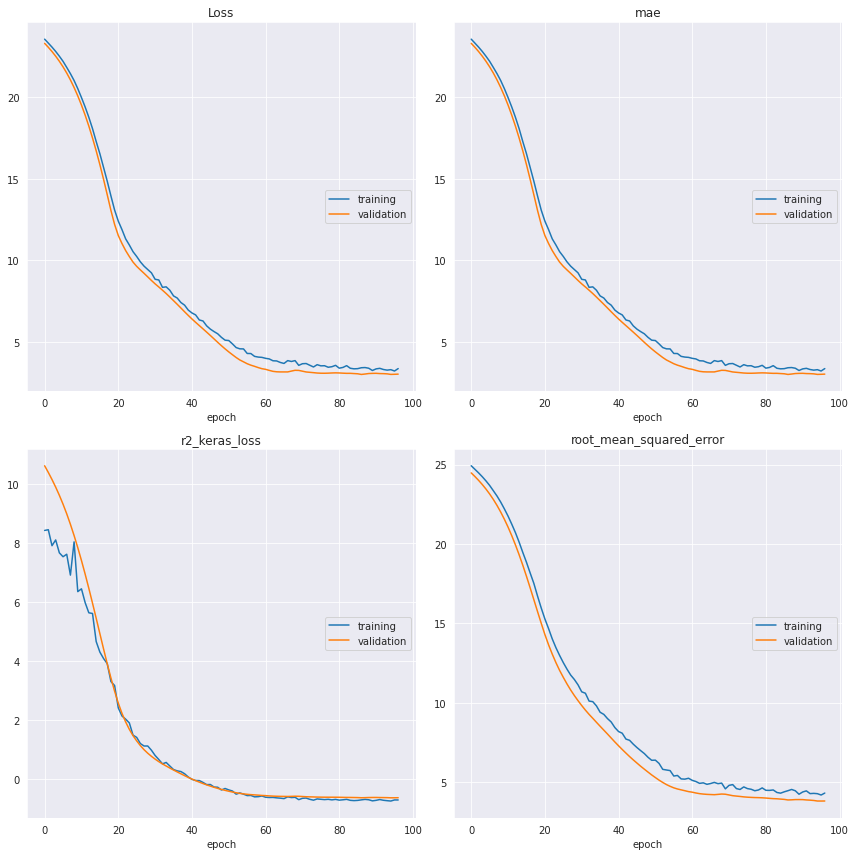

Loss
	training         	 (min:    3.218, max:   23.561, cur:    3.368)
	validation       	 (min:    3.008, max:   23.306, cur:    3.027)
mae
	training         	 (min:    3.218, max:   23.561, cur:    3.368)
	validation       	 (min:    3.008, max:   23.306, cur:    3.027)
r2_keras_loss
	training         	 (min:   -0.739, max:    8.463, cur:   -0.702)
	validation       	 (min:   -0.629, max:   10.632, cur:   -0.626)
root_mean_squared_error
	training         	 (min:    4.182, max:   24.931, cur:    4.306)
	validation       	 (min:    3.803, max:   24.481, cur:    3.805)


In [68]:
#%autoreload 2
if interpretation_possible_autoMPG:
    ((lambda_index_autoMPG, 
     current_seed_autoMPG, 
     polynomial_autoMPG, 
     polynomial_lstsq_pred_list_autoMPG, 
     polynomial_lstsq_true_list_autoMPG), 
    scores_list_autoMPG, 
    pred_list_autoMPG, 
    history_autoMPG, 
    model_autoMPG) = train_nn(lambda_index=0, 
                              X_data_lambda=features_autoMPG_model.values, 
                              y_data_real_lambda=labels_autoMPG.values, 
                              polynomial=None, 
                              seed_list=[RANDOM_SEED], 
                              callbacks=[PlotLossesKerasTF()], 
                              return_history=True, 
                              each_epochs_save=None, 
                              printing=False, 
                              return_model=True)
    
    polynomial_lstsq_pred_autoMPG = polynomial_lstsq_pred_list_autoMPG[-1]

In [69]:
if interpretation_possible_autoMPG:
    x = tf.linspace(0.0, 1, 250)#tf.linspace(0.0, 250, 251)
    y = model_autoMPG.predict(x)

    plt.scatter(features_autoMPG_model['Horsepower'], labels_autoMPG, label='Data')
    plt.plot(x, y, color='k', label='Predictions')
    plt.xlabel('Horsepower')
    plt.ylabel('MPG')
    plt.legend()

ValueError: in user code:

    /home/smarton/anaconda3/envs/xai/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:1478 predict_function  *
        return step_function(self, iterator)
    /home/smarton/anaconda3/envs/xai/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:1468 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    /home/smarton/anaconda3/envs/xai/lib/python3.8/site-packages/tensorflow/python/distribute/distribute_lib.py:1259 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    /home/smarton/anaconda3/envs/xai/lib/python3.8/site-packages/tensorflow/python/distribute/distribute_lib.py:2730 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    /home/smarton/anaconda3/envs/xai/lib/python3.8/site-packages/tensorflow/python/distribute/distribute_lib.py:3417 _call_for_each_replica
        return fn(*args, **kwargs)
    /home/smarton/anaconda3/envs/xai/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:1461 run_step  **
        outputs = model.predict_step(data)
    /home/smarton/anaconda3/envs/xai/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:1434 predict_step
        return self(x, training=False)
    /home/smarton/anaconda3/envs/xai/lib/python3.8/site-packages/tensorflow/python/keras/engine/base_layer.py:998 __call__
        input_spec.assert_input_compatibility(self.input_spec, inputs, self.name)
    /home/smarton/anaconda3/envs/xai/lib/python3.8/site-packages/tensorflow/python/keras/engine/input_spec.py:255 assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer sequential_202 is incompatible with the layer: expected axis -1 of input shape to have value 9 but received input with shape (None, 1)


In [ ]:
config = {
        'n': n,
        'd': d,
        'inet_loss': inet_loss,
        'sparsity': sparsity,
        'lambda_network_layers': lambda_network_layers,
        'interpretation_net_output_shape': interpretation_net_output_shape,
        'RANDOM_SEED': RANDOM_SEED,
        'nas': nas,
        'number_of_lambda_weights': number_of_lambda_weights,
        'interpretation_net_output_monomials': interpretation_net_output_monomials,
        'fixed_initialization_lambda_training': fixed_initialization_lambda_training,
        'dropout': dropout,
        'lambda_network_layers': lambda_network_layers,
        'optimizer_lambda': optimizer_lambda,
        'loss_lambda': loss_lambda,        
         #'list_of_monomial_identifiers': list_of_monomial_identifiers,
         'x_min': x_min,
         'x_max': x_max,
         }

weights_autoMPG = model_autoMPG.get_weights()

weights_flat_autoMPG = []
for layer_weights, biases in pairwise(weights_autoMPG):    #clf.get_weights()
    for neuron in layer_weights:
        for weight in neuron:
            weights_flat_autoMPG.append(weight)
    for bias in biases:
        weights_flat_autoMPG.append(bias)
        
weights_flat_autoMPG = np.array(weights_flat_autoMPG)


x = pred_list_autoMPG['X_test_lambda']
y = pred_list_autoMPG['y_test_real_lambda']

y_model_autoMPG = model_autoMPG.predict(x)




In [ ]:
if interpretation_possible_autoMPG:
    y_polynomial_lstsq_pred_autoMPG = calculate_function_values_from_polynomial(polynomial_lstsq_pred_autoMPG, x, force_complete_poly_representation=True)

    mae_model_polynomial_lstsq_pred_autoMPGy = mean_absolute_error(y_model_autoMPG, y_polynomial_lstsq_pred_autoMPG)
    mae_data_polynomial_lstsq_pred_autoMPG = mean_absolute_error(y, y_polynomial_lstsq_pred_autoMPG)

    print('------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------')
    print('LSTSQt Poly:')
    print_polynomial_from_coefficients(y_polynomial_lstsq_pred_autoMPG, force_complete_poly_representation=True)
    print('MAE Model: ', mae_model_polynomial_lstsq_pred_autoMPGy)
    print('MAE Data: ', mae_data_polynomial_lstsq_pred_autoMPG)
    print('------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------')


In [ ]:
#%autoreload 2
if interpretation_possible_autoMPG:
    interpretation_net = model_list[-1]
    
    start = time.time() 
    
    #interpretation_net_poly = interpretation_net.predict(np.array([weights_flat_autoMPG]))[0]
    interpretation_net_poly = make_inet_prediction(interpretation_net, weights_flat_autoMPG, network_data=None, normalized=False, normalization_parameter_dict=None)
    
    
    end = time.time()     
    generation_time = (end - start) 
    minutes, seconds = divmod(int(generation_time), 60)
    hours, minutes = divmod(minutes, 60)        
    
    y_interpretation_net_poly = calculate_function_values_from_polynomial(interpretation_net_poly, x, force_complete_poly_representation=False)
    
    mae_model_interpretation_net_poly = mean_absolute_error(y_model_autoMPG, y_interpretation_net_poly)
    mae_data_interpretation_net_poly = mean_absolute_error(y, y_interpretation_net_poly)
    
    print('------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------')
    print('Interpretation Net Poly:')
    print_polynomial_from_coefficients(interpretation_net_poly, force_complete_poly_representation=False)
    print('MAE Model: ', mae_model_interpretation_net_poly)
    print('MAE Data: ', mae_data_interpretation_net_poly)    
    print('Computation Time: ' +  f'{hours:d}:{minutes:02d}:{seconds:02d}')    
    print('------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------')
    

In [ ]:
if interpretation_possible_autoMPG:

    start = time.time() 
    
    if False:
        per_network_hyperparams = {
            'optimizer':  'Powell',
            'jac': 'fprime',
            'max_steps': 5000,#100,
            'restarts': 3,
            'per_network_dataset_size': 500,
        }      
        
        per_network_function =  per_network_poly_optimization_scipy(per_network_dataset_size, 
                                                                  weights_flat_autoMPG, 
                                                                  list_of_monomial_identifiers_numbers, 
                                                                  config, 
                                                                  optimizer = per_network_hyperparams['optimizer'],
                                                                  jac = per_network_hyperparams['jac'],
                                                                  max_steps = per_network_hyperparams['max_steps'], 
                                                                  restarts=per_network_hyperparams['restarts'], 
                                                                  printing=True,
                                                                  return_error=False)
    else:
        per_network_hyperparams = {
            'optimizer': tf.keras.optimizers.RMSprop,
            'lr': 0.02,
            'max_steps': 500,
            'early_stopping': 10,
            'restarts': 3,
            'per_network_dataset_size': 5000,
        }   
        
        per_network_function =  per_network_poly_optimization_tf(per_network_hyperparams['per_network_dataset_size'], 
                                                              weights_flat_autoMPG, 
                                                              list_of_monomial_identifiers_numbers, 
                                                              config, 
                                                              optimizer = per_network_hyperparams['optimizer'],
                                                              lr=per_network_hyperparams['lr'], 
                                                              max_steps = per_network_hyperparams['max_steps'], 
                                                              early_stopping=per_network_hyperparams['early_stopping'], 
                                                              restarts=per_network_hyperparams['restarts'], 
                                                              printing=True,
                                                              return_error=False)
            
    end = time.time()     
    generation_time = (end - start) 
    minutes, seconds = divmod(int(generation_time), 60)
    hours, minutes = divmod(minutes, 60)  
    
    y_per_network_function = calculate_function_values_from_polynomial(per_network_function, x, force_complete_poly_representation=False)
    
    mae_model_interpretation_net_poly = mean_absolute_error(y_model_autoMPG, y_per_network_function)
    mae_data_interpretation_net_poly = mean_absolute_error(y, y_per_network_function)    
    
    print('------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------')
    print('Per Network Poly:')
    print_polynomial_from_coefficients(per_network_function)
    print('MAE Model: ', mae_model_interpretation_net_poly)
    print('MAE Data: ', mae_data_interpretation_net_poly)       
    print('Computation Time: ' +  f'{hours:d}:{minutes:02d}:{seconds:02d}')    
    print('------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------')


In [ ]:
if interpretation_possible_autoMPG:
    
    symbolic_regression_hyperparams = {
        'dataset_size': 500,
    }

    start = time.time() 
    
    symbolic_regression_function =  symbolic_regression(model_autoMPG, 
                                                      config,
                                                      symbolic_regression_hyperparams,
                                                      #printing = True,
                                                      return_error = False)
    
    end = time.time()     
    generation_time = (end - start) 
    minutes, seconds = divmod(int(generation_time), 60)
    hours, minutes = divmod(minutes, 60)        
    
    y_symbolic_regression_function = calculate_function_values_from_sympy(symbolic_regression_function, x)
    
    mae_model_symbolic_regression_function = mean_absolute_error(y_model_autoMPG, y_symbolic_regression_function)
    mae_data_symbolic_regression_function = mean_absolute_error(y, y_symbolic_regression_function)
    
    print('------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------')
    print('Symbolic Regression Poly:')    
    display(symbolic_regression_function)
    print('MAE Model: ', mae_model_symbolic_regression_function)
    print('MAE Data: ', mae_data_symbolic_regression_function)      
    print('Computation Time: ' +  f'{hours:d}:{minutes:02d}:{seconds:02d}')    
    print('------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------')
    

In [ ]:
#%autoreload 2
if interpretation_possible_autoMPG and False:
    metamodeling_hyperparams = {
        'num_iter': 500,
        'batch_size': None,
        'learning_rate': 0.01,        
        'dataset_size': 500,
    }
    
    start = time.time() 

    metamodel_function =  symbolic_metamodeling(model_autoMPG, 
                                              config,
                                              metamodeling_hyperparams,
                                              #printing = True,
                                              return_error = False,
                                              return_expression = 'approx', #'approx', #'exact',
                                              function_metamodeling = False,
                                              force_polynomial=False)
    
    end = time.time()     
    generation_time = (end - start) 
    minutes, seconds = divmod(int(generation_time), 60)
    hours, minutes = divmod(minutes, 60)        
    
    y_metamodel_function = calculate_function_values_from_sympy(metamodel_function, x)
    
    mae_model_metamodel_function = mean_absolute_error(y_model_autoMPG, y_metamodel_function)
    mae_data_metamodel_function = mean_absolute_error(y, y_metamodel_function)
    
    print('------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------')
    print('Metamodel Function:')    
    display(metamodel_function)
    print('MAE Model: ', mae_model_metamodel_function)
    print('MAE Data: ', mae_data_metamodel_function)      
    print('Computation Time: ' +  f'{hours:d}:{minutes:02d}:{seconds:02d}')    
    print('------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------')
    

In [ ]:
if interpretation_possible_autoMPG and False:
    metamodeling_hyperparams = {
        'num_iter': 500,
        'batch_size': None,
        'learning_rate': 0.01,        
        'dataset_size': 500,
    }
    
    start = time.time() 

    metamodel_function_basic =  symbolic_metamodeling(model_autoMPG, 
                                              config,
                                              metamodeling_hyperparams,
                                              #printing = True,
                                              return_error = False,
                                              return_expression = 'approx', #'approx', #'exact',
                                              function_metamodeling = True,
                                              force_polynomial=False)
    
    end = time.time()     
    generation_time = (end - start) 
    minutes, seconds = divmod(int(generation_time), 60)
    hours, minutes = divmod(minutes, 60)        
    
    y_metamodel_function_basic = calculate_function_values_from_sympy(metamodel_function_basic, x)
    
    mae_metamodel_function_basic = mean_absolute_error(y_model_autoMPG, y_metamodel_function_basic)
    mae_metamodel_function_basic = mean_absolute_error(y, y_metamodel_function_basic)
    
    print('------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------')
    print('Metamodel Function Basic:')    
    display(metamodel_function_basic)
    print('MAE Model: ', mae_metamodel_function_basic)
    print('MAE Data: ', mae_metamodel_function_basic)      
    print('Computation Time: ' +  f'{hours:d}:{minutes:02d}:{seconds:02d}')    
    print('------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------')
    

In [ ]:
if interpretation_possible_autoMPG:
    print('------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------')
    print('------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------')
    print('Interpretation Net Poly:')
    print_polynomial_from_coefficients(interpretation_net_poly, force_complete_poly_representation=False)
    print('------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------')
    print('Per Network Poly:')
    print_polynomial_from_coefficients(per_network_function, force_complete_poly_representation=False)
    print('------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------')
    print('LSTSQ Poly:')
    print_polynomial_from_coefficients(polynomial_lstsq_pred_autoMPG, force_complete_poly_representation=True)
    print('------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------')
    print('Symbolic Regression Function:')
    display(symbolic_regression_function)
    #print('------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------')
    #print('Metamodel Function:')
    #display(metamodel_function)
    #print('------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------')
    #print('Metamodel Function Basic:')
    #display(metamodel_function_basic)
    print('------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------')
    print('------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------')


In [ ]:
if interpretation_possible_autoMPG:
    fig, ax = plt.subplots(1, 1, figsize=(20,10))
    
    ax.set_ylim([0,50])
    
    plt.scatter(features_autoMPG_model['Horsepower'], labels_autoMPG, label='Data')
    plt.scatter(x, y, label='Test Data')
    plt.plot(np.sort(x, axis=0), np.array([y for _, y in sorted(zip(x, y_model_autoMPG))]) , label='Model Predictions')
    plt.plot(np.sort(x, axis=0), np.array([y for _, y in sorted(zip(x, y_interpretation_net_poly))]) , label='Interpretation Net Poly')
    #plt.plot(np.sort(x, axis=0), np.array([y for _, y in sorted(zip(x, y_per_network_function))]) , label='Per Network Poly')
    plt.plot(np.sort(x, axis=0), np.array([y for _, y in sorted(zip(x, y_polynomial_lstsq_pred_autoMPG))]) , label='LSTSQ Poly')
    plt.plot(np.sort(x, axis=0), np.array([y for _, y in sorted(zip(x, y_symbolic_regression_function))]) , label='Symbolic Regression Function')
    #plt.plot(np.sort(x, axis=0), np.array([y for _, y in sorted(zip(x, y_metamodel_function))]) , label='Metamodel Function')
    #plt.plot(np.sort(x, axis=0), np.array([y for _, y in sorted(zip(x, y))]) y_metamodel_function_basic, label='Metamodel Function Basic')
    plt.xlabel('Horsepower')
    plt.ylabel('MPG')
    plt.legend()

In [ ]:
sample_data_X = np.array([i for i in range(1000)])
sample_data_y = np.array([3*i for i in range(1000)])


In [ ]:
current_seed = 42

In [ ]:
random.seed(current_seed)
np.random.seed(current_seed)
if int(tf.__version__[0]) >= 2:
    tf.random.set_seed(current_seed)
else:
    tf.set_random_seed(current_seed) 

In [ ]:
model = keras.models.Sequential()

model.add(Dense(5, input_shape=(1,), activation='relu'))
model.add(Dense(3, activation='relu'))
model.add(Dense(1))

model.compile(loss='mae', optimizer='adam')
          
    
model.summary()

In [ ]:
model.fit(sample_data_X,
         sample_data_y,
         epochs=5000,
         verbose=0)

In [ ]:
model.get_weights()

In [ ]:
model.predict([1, 10])

In [ ]:
random.seed(current_seed)
np.random.seed(current_seed)
if int(tf.__version__[0]) >= 2:
    tf.random.set_seed(current_seed)
else:
    tf.set_random_seed(current_seed) 

In [ ]:
model = keras.models.Sequential()

model.add(Dense(5, input_shape=(1,), activation='relu'))
model.add(Dense(3, activation='relu'))
model.add(Dense(1))

model.compile(loss='mae', optimizer='adam')
          
    
model.summary()

In [ ]:
model.fit(sample_data_X,
         sample_data_y*1000,
         epochs=5000,
         verbose=0)

In [ ]:
model.get_weights()

In [ ]:
model.predict([1, 10])

In [ ]:
model = keras.models.Sequential()

model.add(Dense(5, input_shape=(1,), activation='relu'))
model.add(Dense(3, activation='relu'))
model.add(Dense(1))

model.compile(loss='mae', optimizer='adam')
          
    
model.summary()

In [ ]:
model.fit(sample_data_X,
         sample_data_y,
         epochs=500,
         verbose=0)

In [ ]:
model_2 = keras.models.clone_model(model)

model_2.summary()

In [ ]:
model.get_weights()

In [ ]:
model.predict([1, 10])

In [ ]:
model_2_weights = model.get_weights()
model_2_normalized_weights = model_2_weights #[weights/10 for weights in model_2_weights]

In [ ]:
model_2_normalized_weights[-6] = model_2_normalized_weights[-6]/10
model_2_normalized_weights[-5] = model_2_normalized_weights[-5]/10

model_2_normalized_weights[-4] = model_2_normalized_weights[-4]/10
model_2_normalized_weights[-3] = model_2_normalized_weights[-3]/100

model_2_normalized_weights[-2] = model_2_normalized_weights[-2]/10
model_2_normalized_weights[-1] = model_2_normalized_weights[-1]/1000

In [ ]:
#model_2_normalized_weights[-2] = model_2_normalized_weights[-2]/1000
#model_2_normalized_weights[-1] = model_2_normalized_weights[-1]/1000

In [ ]:
model_2.set_weights(model_2_normalized_weights)

In [ ]:
model_2.get_weights()

In [ ]:
model_2.predict([1, 10])

In [ ]:
    #Plot Polynom, lamdba net, and Interpration net
    length_plt = len(plot_metric_list)
    if length_plt >= 2:
        fig, ax = plt.subplots(length_plt//2, 2, figsize=(30,20))
    else:
        fig, ax = plt.subplots(1, 1, figsize=(20,10))

    for index, metric in enumerate(plot_metric_list):
        
        plot_scores_dict = {}
        for key in evaluation_key_list:
            try:
                scores_list[-1][metric].loc[key]
                plot_scores_dict[key] = []
            except:
                #print(key + 'not in scores_list')
                continue
            
        
        for scores in scores_list:
            for key in evaluation_key_list:
                try:
                    plot_scores_dict[key].append(scores[metric].loc[key])
                except:
                    #print(key + 'not in scores_list')
                    continue
                                        
            
        plot_df = pd.DataFrame(data=np.vstack(plot_scores_dict.values()).T, 
                               index=x_axis_steps,
                               columns=plot_scores_dict.keys())

        if length_plt >= 2:
            ax[index//2, index%2].set_title(metric)
            sns.set(font_scale = 1.25)
            p = sns.lineplot(data=plot_df, ax=ax[index//2, index%2])
        else:
            ax.set_title(metric)
            sns.set(font_scale = 1.25)
            p = sns.lineplot(data=plot_df, ax=ax)

        if ylim != None:
            p.set(ylim=ylim)

        p.set_yticklabels(np.round(p.get_yticks(), 2), size = 20)
        p.set_xticklabels(p.get_xticks(), size = 20)     
        
        #p.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
        p.legend(loc='upper center', bbox_to_anchor=(0.47, -0.1),
          fancybox=False, shadow=False, ncol=2, fontsize=12)   
        
    plt.subplots_adjust(wspace=0.1, hspace=0.75)

# Evaluate Per-Network Poly Optimization

## Example Optimization (Common Optimizer)

In [ ]:
random_index = RANDOM_SEED

per_network_hyperparams = {
    'optimizer':  'Powell',
    'jac': 'fprime',
    'max_steps': 5000,#100,
    'restarts': 3,
    'per_network_dataset_size': 500,
}

lambda_net_test_dataset = lambda_net_test_dataset_list[-1]
lambda_network_weights_list = np.array(lambda_net_test_dataset.weight_list)
lambda_network_weights = lambda_network_weights_list[random_index]

list_of_monomial_identifiers_numbers = np.array([list(monomial_identifiers) for monomial_identifiers in list_of_monomial_identifiers]).astype(float)  

printing = True

config = {
         'n': n,
         'inet_loss': inet_loss,
         'sparsity': sparsity,
         'lambda_network_layers': lambda_network_layers,
         'interpretation_net_output_shape': interpretation_net_output_shape,
         'RANDOM_SEED': RANDOM_SEED,
         'nas': nas,
         'number_of_lambda_weights': number_of_lambda_weights,
         'interpretation_net_output_monomials': interpretation_net_output_monomials,
         'x_min': x_min,
         'x_max': x_max,
         }


per_network_optimization_error, per_network_optimization_polynomial = per_network_poly_optimization_scipy(per_network_hyperparams['per_network_dataset_size'], 
                                                                                                      lambda_network_weights, 
                                                                                                      list_of_monomial_identifiers_numbers, 
                                                                                                      config,
                                                                                                      optimizer = per_network_hyperparams['optimizer'],
                                                                                                      jac = per_network_hyperparams['jac'],
                                                                                                      max_steps = per_network_hyperparams['max_steps'], 
                                                                                                      restarts = per_network_hyperparams['restarts'],
                                                                                                      printing = True,
                                                                                                      return_error = True)

print('\n\nError: ' + str(per_network_optimization_error))
print_polynomial_from_coefficients(per_network_optimization_polynomial)



## Example Optimization (Neural Optimizer)

In [ ]:
random_index = RANDOM_SEED

per_network_hyperparams = {
    'optimizer': tf.keras.optimizers.RMSprop,
    'lr': 0.02,
    'max_steps': 500,
    'early_stopping': 10,
    'restarts': 3,
    'per_network_dataset_size': 5000,
}

lambda_net_test_dataset = lambda_net_test_dataset_list[-1]
lambda_network_weights_list = np.array(lambda_net_test_dataset.weight_list)
lambda_network_weights = lambda_network_weights_list[random_index]

list_of_monomial_identifiers_numbers = np.array([list(monomial_identifiers) for monomial_identifiers in list_of_monomial_identifiers]).astype(float)  

printing = True

config = {
         'n': n,
         'inet_loss': inet_loss,
         'sparsity': sparsity,
         'lambda_network_layers': lambda_network_layers,
         'interpretation_net_output_shape': interpretation_net_output_shape,
         'RANDOM_SEED': RANDOM_SEED,
         'nas': nas,
         'number_of_lambda_weights': number_of_lambda_weights,
         'interpretation_net_output_monomials': interpretation_net_output_monomials,
         'x_min': x_min,
         'x_max': x_max,
         }


per_network_optimization_error, per_network_optimization_polynomial = per_network_poly_optimization_tf(per_network_hyperparams['per_network_dataset_size'], 
                                                                                                      lambda_network_weights, 
                                                                                                      list_of_monomial_identifiers_numbers, 
                                                                                                      config,
                                                                                                      optimizer = per_network_hyperparams['optimizer'],
                                                                                                      lr = per_network_hyperparams['lr'], 
                                                                                                      max_steps = per_network_hyperparams['max_steps'], 
                                                                                                      early_stopping = per_network_hyperparams['early_stopping'], 
                                                                                                      restarts = per_network_hyperparams['restarts'],
                                                                                                      printing = True,
                                                                                                      return_error = True)

print('\n\nError: ' + str(per_network_optimization_error.numpy()))
print_polynomial_from_coefficients(per_network_optimization_polynomial)



## Grid Search Common Optimizers

In [ ]:
%%script false --no-raise-error

pd.set_option('max_colwidth', 100)

evaluation_size = 10

per_network_hyperparams = {
    'optimizer':  [
                   'Nelder-Mead', 
                   'Powell', 
        
                   'CG',
                   'BFGS',
                   'Newton-CG', 
                   #'L-BFGS-B', #'>' not supported between instances of 'int' and 'NoneType'
                   'TNC', 
                   
                   'COBYLA', 
                   'SLSQP', 
                   
                   #'trust-constr', # TypeError: _minimize_trustregion_constr() got an unexpected keyword argument 'maxfun'
                   #'dogleg', # ValueError: Hessian is required for dogleg minimization
                   #'trust-ncg', #ValueError: Either the Hessian or the Hessian-vector product is required for Newton-CG trust-region minimization
                   #'trust-exact', # ValueError: Hessian matrix is required for trust region exact minimization.
                   #'trust-krylov' #ValueError: Either the Hessian or the Hessian-vector product is required for Krylov trust-region minimization
                   ], 
    'jac': ['fprime'],
    'max_steps': [5000],#100,
    'restarts': [3],
    'per_network_dataset_size': [500],
}

#param_iterator = ParameterSampler(per_network_hyperparams, n_iter=60, random_state=RANDOM_SEED)
param_iterator = ParameterGrid(per_network_hyperparams)


lambda_net_test_dataset = lambda_net_test_dataset_list[-1]
lambda_network_weights_list = np.array(lambda_net_test_dataset.weight_list)

list_of_monomial_identifiers_numbers = np.array([list(monomial_identifiers) for monomial_identifiers in list_of_monomial_identifiers]).astype(float)  
printing = True if n_jobs == 1 else False

config = {
         'n': n,
         'inet_loss': inet_loss,
         'sparsity': sparsity,
         'lambda_network_layers': lambda_network_layers,
         'interpretation_net_output_shape': interpretation_net_output_shape,
         'RANDOM_SEED': RANDOM_SEED,
         'nas': nas,
         'number_of_lambda_weights': number_of_lambda_weights,
         'interpretation_net_output_monomials': interpretation_net_output_monomials,
         'x_min': x_min,
         'x_max': x_max,
         }

In [ ]:
%%script false --no-raise-error

params_error_list = []
for params in tqdm(param_iterator):
    parallel_per_network = Parallel(n_jobs=n_jobs, verbose=0, backend='loky')

    result_list = parallel_per_network(delayed(per_network_poly_optimization_scipy)(params['per_network_dataset_size'], 
                                                                                  lambda_network_weights, 
                                                                                  list_of_monomial_identifiers_numbers, 
                                                                                  config,
                                                                                  optimizer = params['optimizer'],
                                                                                  jac = params['jac'],
                                                                                  max_steps = params['max_steps'], 
                                                                                  restarts = params['restarts'],
                                                                                  printing = printing,
                                                                                  return_error = True) for lambda_network_weights in lambda_network_weights_list[:evaluation_size])  
    
    
    per_network_optimization_errors = [result[0] for result in result_list]
    per_network_optimization_polynomials = [result[1] for result in result_list]
        
    params_score = np.mean(per_network_optimization_errors)
    
    evaluation_result = list(params.values())
    evaluation_result.append(params_score)
    
    params_error_list.append(evaluation_result)
        
    del parallel_per_network

columns = list(params.keys())
columns.append('score')
params_error_df = pd.DataFrame(data=params_error_list, columns=columns).sort_values(by='score')
params_error_df.head(10) 

## Grid Search Neural Optimizers

In [ ]:
%%script false --no-raise-error

pd.set_option('max_colwidth', 100)

evaluation_size = 100

per_network_hyperparams = {
    'optimizer': [tf.keras.optimizers.RMSprop], #[tf.keras.optimizers.SGD, tf.optimizers.Adam, tf.keras.optimizers.RMSprop, tf.keras.optimizers.Adadelta]
    'lr': [0.02], #[0.5, 0.25, 0.1, 0.05, 0.025]
    'max_steps': [5000],#100,
    'early_stopping': [10],
    'restarts': [3],
    'per_network_dataset_size': [5000],
}

#param_iterator = ParameterSampler(per_network_hyperparams, n_iter=60, random_state=RANDOM_SEED)
param_iterator = ParameterGrid(per_network_hyperparams)


lambda_net_test_dataset = lambda_net_test_dataset_list[-1]
lambda_network_weights_list = np.array(lambda_net_test_dataset.weight_list)

list_of_monomial_identifiers_numbers = np.array([list(monomial_identifiers) for monomial_identifiers in list_of_monomial_identifiers]).astype(float)  
printing = True if n_jobs == 1 else False

config = {
         'n': n,
         'inet_loss': inet_loss,
         'sparsity': sparsity,
         'lambda_network_layers': lambda_network_layers,
         'interpretation_net_output_shape': interpretation_net_output_shape,
         'RANDOM_SEED': RANDOM_SEED,
         'nas': nas,
         'number_of_lambda_weights': number_of_lambda_weights,
         'interpretation_net_output_monomials': interpretation_net_output_monomials,
         'x_min': x_min,
         'x_max': x_max,
         }

In [ ]:
%%script false --no-raise-error

params_error_list = []
for params in tqdm(param_iterator):
    parallel_per_network = Parallel(n_jobs=n_jobs, verbose=0, backend='loky')

    result_list = parallel_per_network(delayed(per_network_poly_optimization_tf)(params['per_network_dataset_size'], 
                                                                                  lambda_network_weights, 
                                                                                  list_of_monomial_identifiers_numbers, 
                                                                                  config,
                                                                                  optimizer = params['optimizer'],
                                                                                  lr = params['lr'], 
                                                                                  max_steps = params['max_steps'], 
                                                                                  early_stopping = params['early_stopping'], 
                                                                                  restarts = params['restarts'],
                                                                                  printing = printing,
                                                                                  return_error = True) for lambda_network_weights in lambda_network_weights_list[:evaluation_size])  
    
    
    per_network_optimization_errors = [result[0] for result in result_list]
    per_network_optimization_polynomials = [result[1] for result in result_list]
        
    params_score = np.mean(per_network_optimization_errors)
    
    evaluation_result = list(params.values())
    evaluation_result.append(params_score)
    
    params_error_list.append(evaluation_result)
        
    del parallel_per_network

columns = list(params.keys())
columns.append('score')
params_error_df = pd.DataFrame(data=params_error_list, columns=columns).sort_values(by='score')
params_error_df.head(10) 

In [ ]:
if use_gpu:
    from numba import cuda 
    device = cuda.get_current_device()
    device.reset()